In [1]:
options(repr.plot.width=18, repr.plot.height=18)

In [2]:
library(ggplot2)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [327]:
demo=read.csv(file="/Users/sarah/Documents/SCTLD/SCTLD_samples/Survey_Data/CBC_Coral_Demographics.csv")

In [328]:


levels(as.factor(demo$location_name))


[1] "Bread and Butter Patch" "CBC 15 South"           "CBC 30 North"          
 [4] "CBC House Reef"         "CBC Lagoon Reef"        "CBC Reef Central"      
 [7] "Curlew Patch Reef"      "Hangman"                "Hangman "              
[10] "South Reef 15 South"    "South Reef 30 North"    "South Reef 30 South"   
[13] "South Reef 30 South "   "South Reef Central"     "Tobacco Reef"

In [329]:
demo$ID=NULL
demo$latitude=NULL
demo$longitude=NULL
demo$X0_recent_total_mortality=NULL
demo$predation_bites=NULL
demo$X=NULL
demo$depth=NULL
demo$buddy=NULL

In [330]:
##make timepoint column
demo$year <- as.factor(demo$year)
levels(demo$year)

demo <- demo %>% subset(year != 0) %>% droplevels()

demo <- demo %>% mutate(time_point = "x") %>%
  mutate(time_point = case_when(
    year == "2019"|year == "2020" ~ "Oct19",
    TRUE ~ as.character(time_point))) %>% 
  mutate(time_point = case_when(
    year == "2022" & month == "5" ~ "May22",
    TRUE ~ as.character(time_point))) %>% 
  mutate(time_point = case_when(
    year == "2022" & month == "12" ~ "Dec22",
    TRUE ~ as.character(time_point)))


[1] "2019" "2020" "2022" "2023" "2024" "2025"

In [331]:
class(demo$time_point)

[1] "character"

In [403]:
demo$scientific_name <- as.factor(demo$scientific_name)
levels(demo$scientific_name)

c <- demo %>% subset(scientific_name == "MYCE")

#remove unknown (LA?), lumped ORBIs and AGARs (uncommon, mainly a Leah thing), and MCOM

demo <- demo %>% subset(scientific_name != "LA(?)" &
                          scientific_name != "ORBI" &
                          scientific_name != "AGAR" &
                          scientific_name != "MCOM" &
                          scientific_name != "MYCE") %>% droplevels()
demo$scientific_name <- recode(demo$scientific_name, "PSTRI" = "PSTR",
                               "DSTR" = "PSTR",
                               "ISRI" = "IRIG")

[1] ""                          "Acropora cervicornis"     
 [3] "Agaricia agaricites"       "Agaricia fragilis"        
 [5] "Agaricia lamarckiana"      "Agaricia tenuifolia"      
 [7] "Colpophyllia natans"       "Dendrogyra cylindrus"     
 [9] "Dichocoenia stokesii"      "Diploria labyrinthiformis"
[11] "Eusmilia fastigiata"       "Favia fragum"             
[13] "Helioseris cucullata"      "Isophyllia rigida"        
[15] "Isophyllia sinuosa"        "Madracis decactis"        
[17] "Madracis decactis "        "Meandrina meandrites"     
[19] "Millepora Complanata"      "Montrastraea cavernosa"   
[21] "Mycetophyllia aliciae"     "Mycetophyllia spp."       
[23] "Orbicella annularis"       "Orbicella faveolata"      
[25] "Orbicella franksi"         "Orbicella spp."           
[27] "Porites astreoides"        "Porites divaricata"       
[29] "Porites furcata"           "Porites furcata "         
[31] "Porites porites"           "Porites Porites"          
[33] "Porites porities"          "Pseudodiploria clivosa"   
[35] "Pseudodiploria strigosa"   "Scolymia cubensis"        
[37] "Siderastrea radians"       "Siderastrea siderea"      
[39] "Stephanocoenia intersepta"

In [404]:
#take out relevant years and remove unneeded columns
demoSCTLD=demo[demo$year %in% c("2019", "2020", "2022"),]
#demoSCTLD$yearmonth=paste0(demoSCTLD$year,demoSCTLD$month)
#demoSCTLD$yearmonth=gsub("20201", "202001",  demoSCTLD$yearmonth)
#demoSCTLD$yearmonth=gsub("20225", "202205",  demoSCTLD$yearmonth)
demoSCTLD$diver=NULL
demoSCTLD$site_code=NULL
demoSCTLD$month=NULL
demoSCTLD$year=NULL
demoSCTLD$day=NULL

In [405]:
#make all orbicellas one category
demoSCTLD$code <- gsub("ofav|oann|ofra", "orbi", demoSCTLD$code)

In [406]:
#when there are multiple entries add them together
demoSCTLD=demoSCTLD%>%
group_by(across(where(is.character))) %>%
 summarise(across(where(is.numeric), sum), .groups = "drop")

In [407]:
head(demoSCTLD)

location_name code time_point Total juveniles_1_to_4_cm isolate_1_to_4_cm
1 CBC 30 North  aaga Dec22      33    0                   1                
2 CBC 30 North  aaga May22      46    9                   1                
3 CBC 30 North  aaga Oct19      83    4                   4                
4 CBC 30 North  alam Oct19       1    0                   0                
5 CBC 30 North  aten Dec22      16    0                   0                
6 CBC 30 North  aten May22      21    0                   0                
  X5_to_10_cm X11_to_20_cm X21_to_40_cm X41_to_80_cm over_80_cm
1 16          12           4            0            0         
2 23          11           2            0            0         
3 51          24           0            0            0         
4  1           0           0            0            0         
5  0           6           8            1            1         
6  2           9           6            4            0

In [408]:
#set site names and colors
demoSCTLD <- demoSCTLD %>% subset(location_name != "")

sitecolors = c('CBC Central'='red3','CBC Lagoon'='darkorchid','CBC30N'='gold1',
               'Curlew Patch' = 'blue', 'House Reef' ='seagreen4', 
               'South Reef Central' = 'orange', 'SR30N' = 'pink')

demoSCTLD$location_name <- recode(demoSCTLD$location_name, 
                             "CBC 30 C" = "CBC Central",
                             "South Reef 30 C" = "South Reef Central",
                             "CBC 30 North" = "CBC30N",
                             "South Reef 30 North" = "SR30N",
                             "CBC House Reef" = "House Reef",
                             "CBC Reef Centra" = "CBC Central",
                             "Curlew Patch Reef" = "Curlew Patch",
                             "CBC Lagoon Reef" = "CBC Lagoon", 
                             "CBC Reef Central" = "CBC Central")

demoSCTLD <- demoSCTLD %>% subset(location_name != "Tobacco Reef")

In [409]:
demoSCTLD$non_juv=demoSCTLD$Total-(demoSCTLD$juveniles_1_to_4_cm+demoSCTLD$isolate_1_to_4_cm)

In [410]:
head(demoSCTLD)

location_name code time_point Total juveniles_1_to_4_cm isolate_1_to_4_cm
1 CBC30N        aaga Dec22      33    0                   1                
2 CBC30N        aaga May22      46    9                   1                
3 CBC30N        aaga Oct19      83    4                   4                
4 CBC30N        alam Oct19       1    0                   0                
5 CBC30N        aten Dec22      16    0                   0                
6 CBC30N        aten May22      21    0                   0                
  X5_to_10_cm X11_to_20_cm X21_to_40_cm X41_to_80_cm over_80_cm non_juv
1 16          12           4            0            0          32     
2 23          11           2            0            0          36     
3 51          24           0            0            0          75     
4  1           0           0            0            0           1     
5  0           6           8            1            1          16     
6  2           9           6            4            0          21

In [411]:
demoSCTLD=demoSCTLD[c(1:4, 12)]

In [412]:
demoSCTLD$time_point <- factor(demoSCTLD$time_point, levels=c("Oct19", "May22", "Dec22"))

In [413]:
head(demoSCTLD)

location_name code time_point Total non_juv
1 CBC30N        aaga Dec22      33    32     
2 CBC30N        aaga May22      46    36     
3 CBC30N        aaga Oct19      83    75     
4 CBC30N        alam Oct19       1     1     
5 CBC30N        aten Dec22      16    16     
6 CBC30N        aten May22      21    21

In [414]:
demosum <- demoSCTLD %>% group_by(code) %>%
  summarize(total_nj = sum(non_juv)) 

In [415]:
demosum

code total_nj
1  aaga 1464    
2  acer    4    
3  agar    1    
4  alam    1    
5  aten  859    
6  cnat    3    
7  dcyl    1    
8  dlab   10    
9  dsto   23    
10 efas   12    
11 ffra    0    
12 hcuc   16    
13 irig    2    
14 isin    1    
15 mali    1    
16 mcav   91    
17 mdec   22    
18 mmea    8    
19 myce    2    
20 orbi  239    
21 past 1065    
22 pcli    2    
23 ppor  421    
24 pstr   79    
25 scub    0    
26 sint   67    
27 srad  111    
28 ssid  648

In [416]:
##exclude species with less than 5 overall
exclude=c("acer", "agar", "alam", "cnat", "dcyl", "ffra", "irig", "isin", "mali", "myce", "pcli", "scub")

In [417]:
high=demoSCTLD[demoSCTLD$code %in% c("aaga", "aten", "past", "ppor"),]

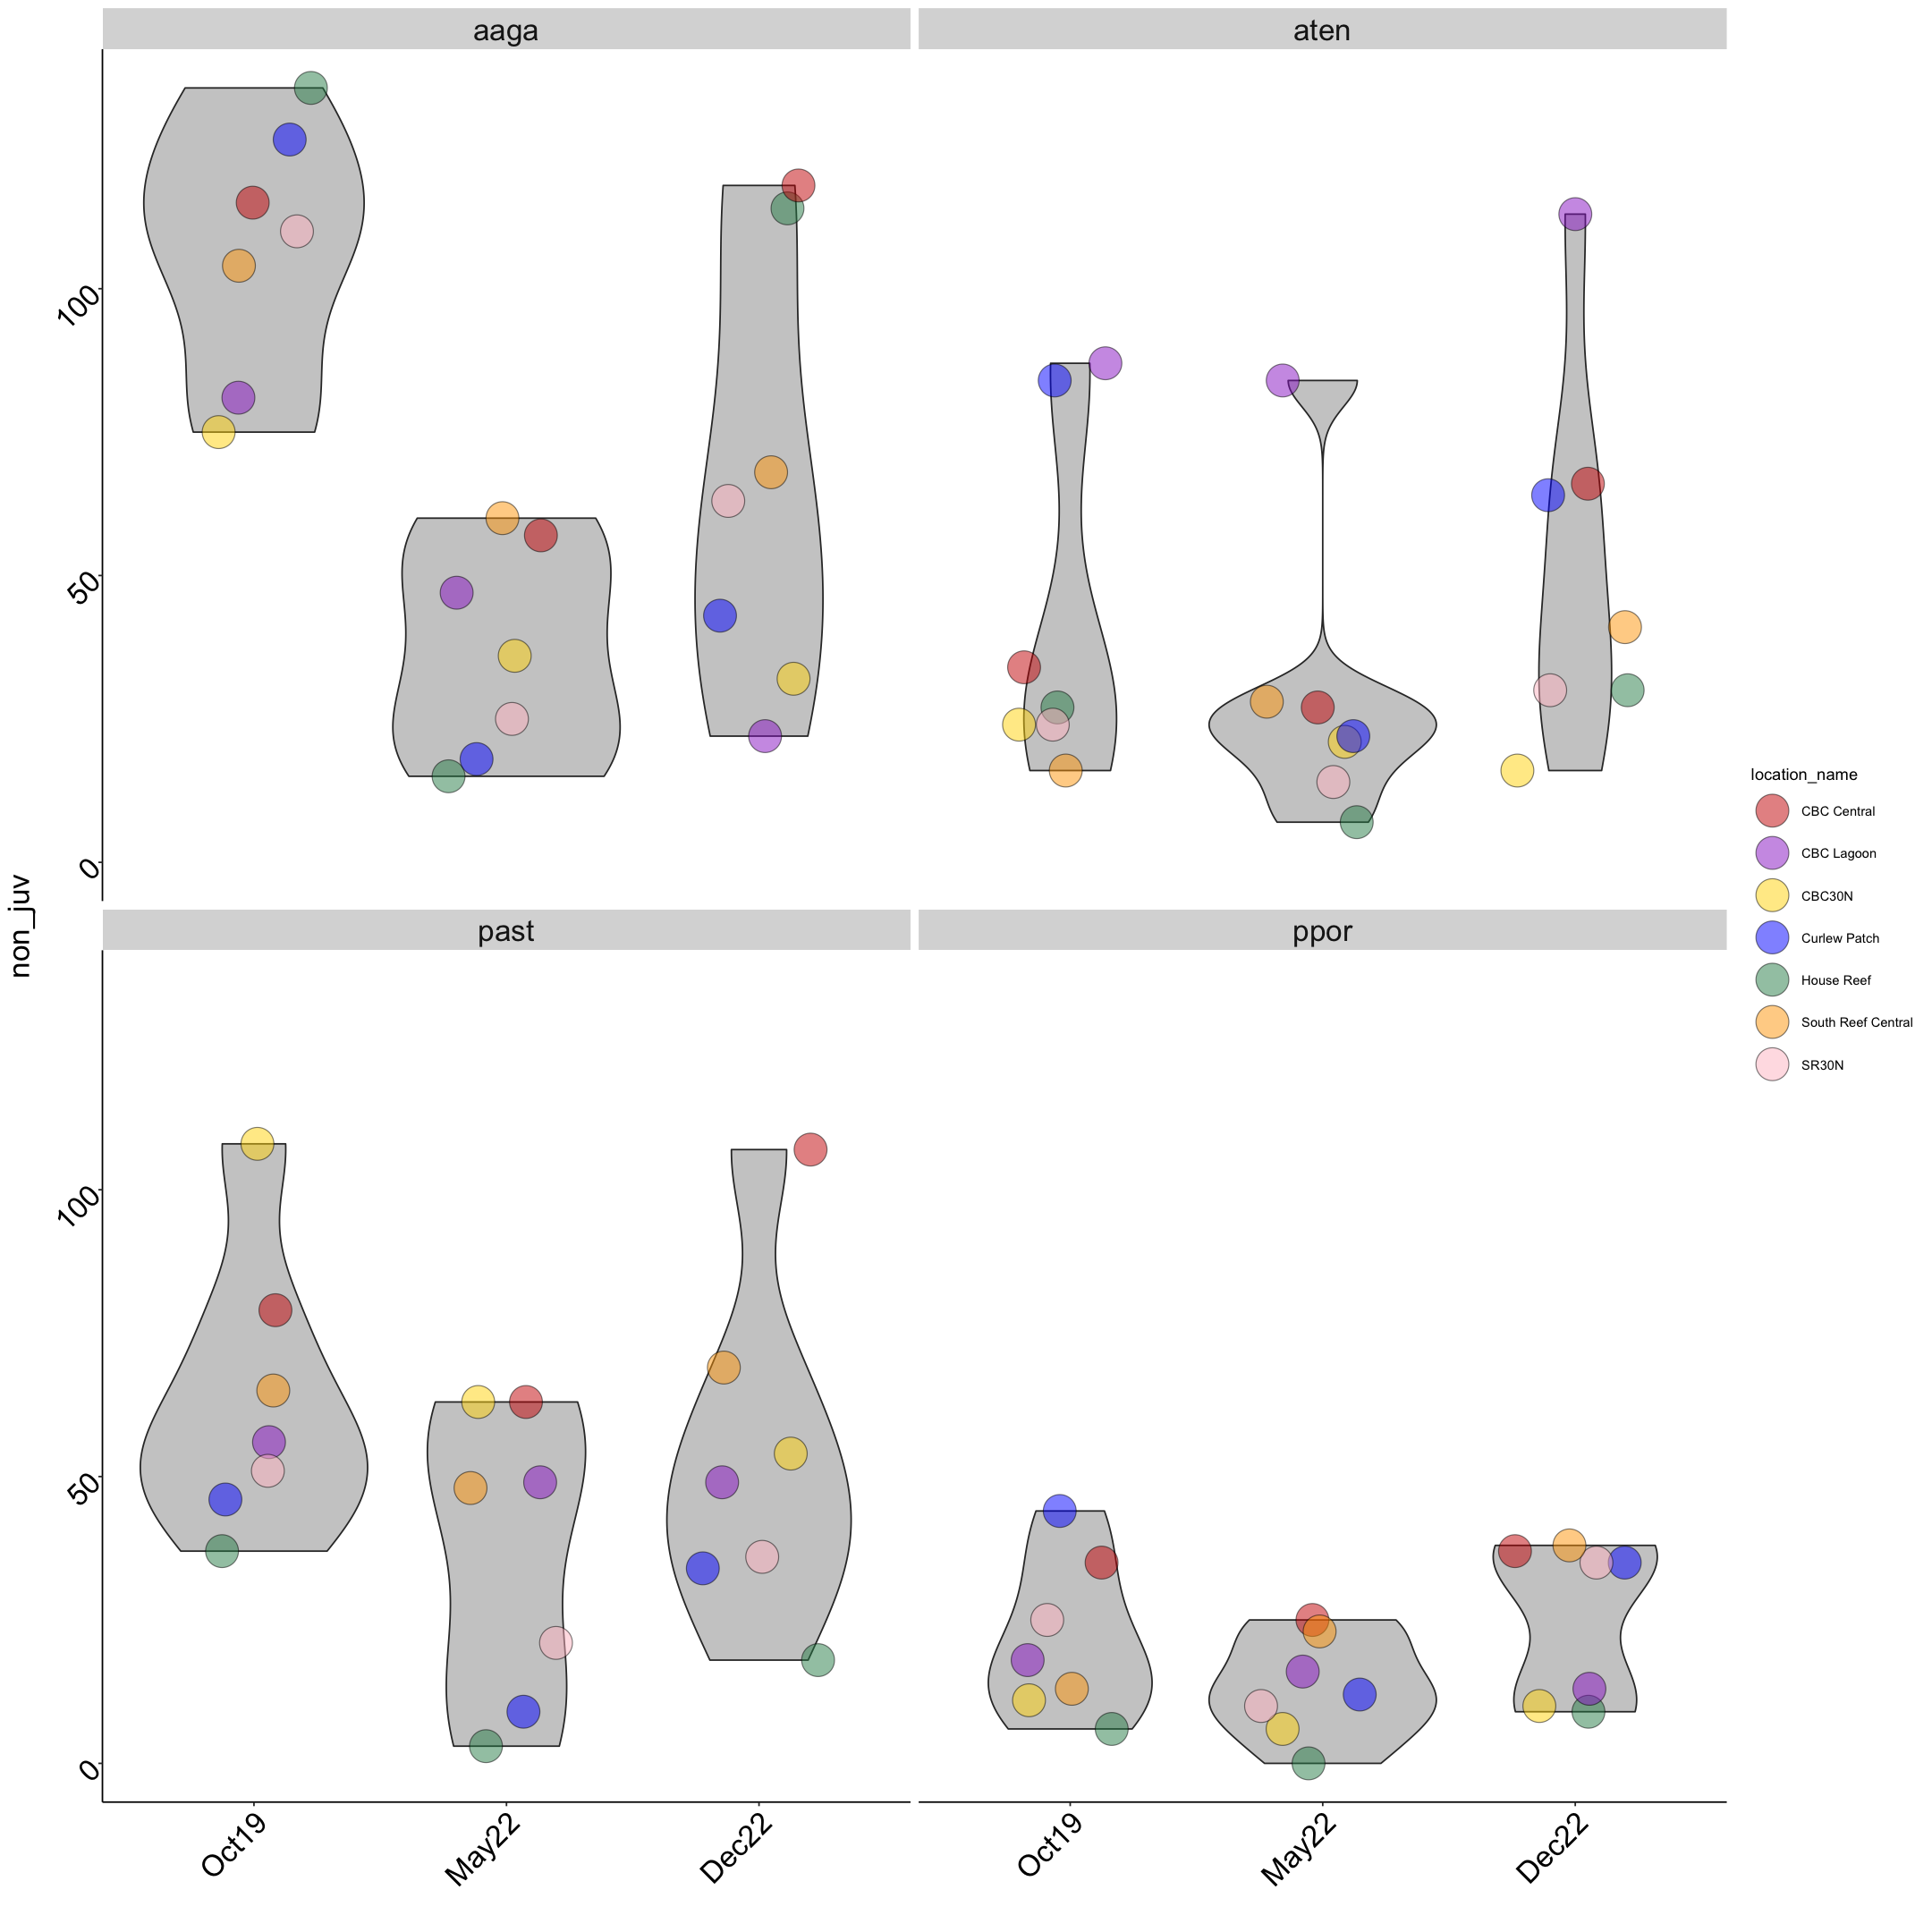

In [418]:
ggplot() +
  geom_violin(data = high, aes(x = time_point, y = non_juv), fill = "gray80") +
  geom_jitter(data = high, aes(x = time_point, y = non_juv, fill = location_name), size = 10, pch = 21, alpha=0.5,  
              width = 0.25, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code, ncol = 2) +
  #scale_y_continuous("Mean Density/m2") +
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))

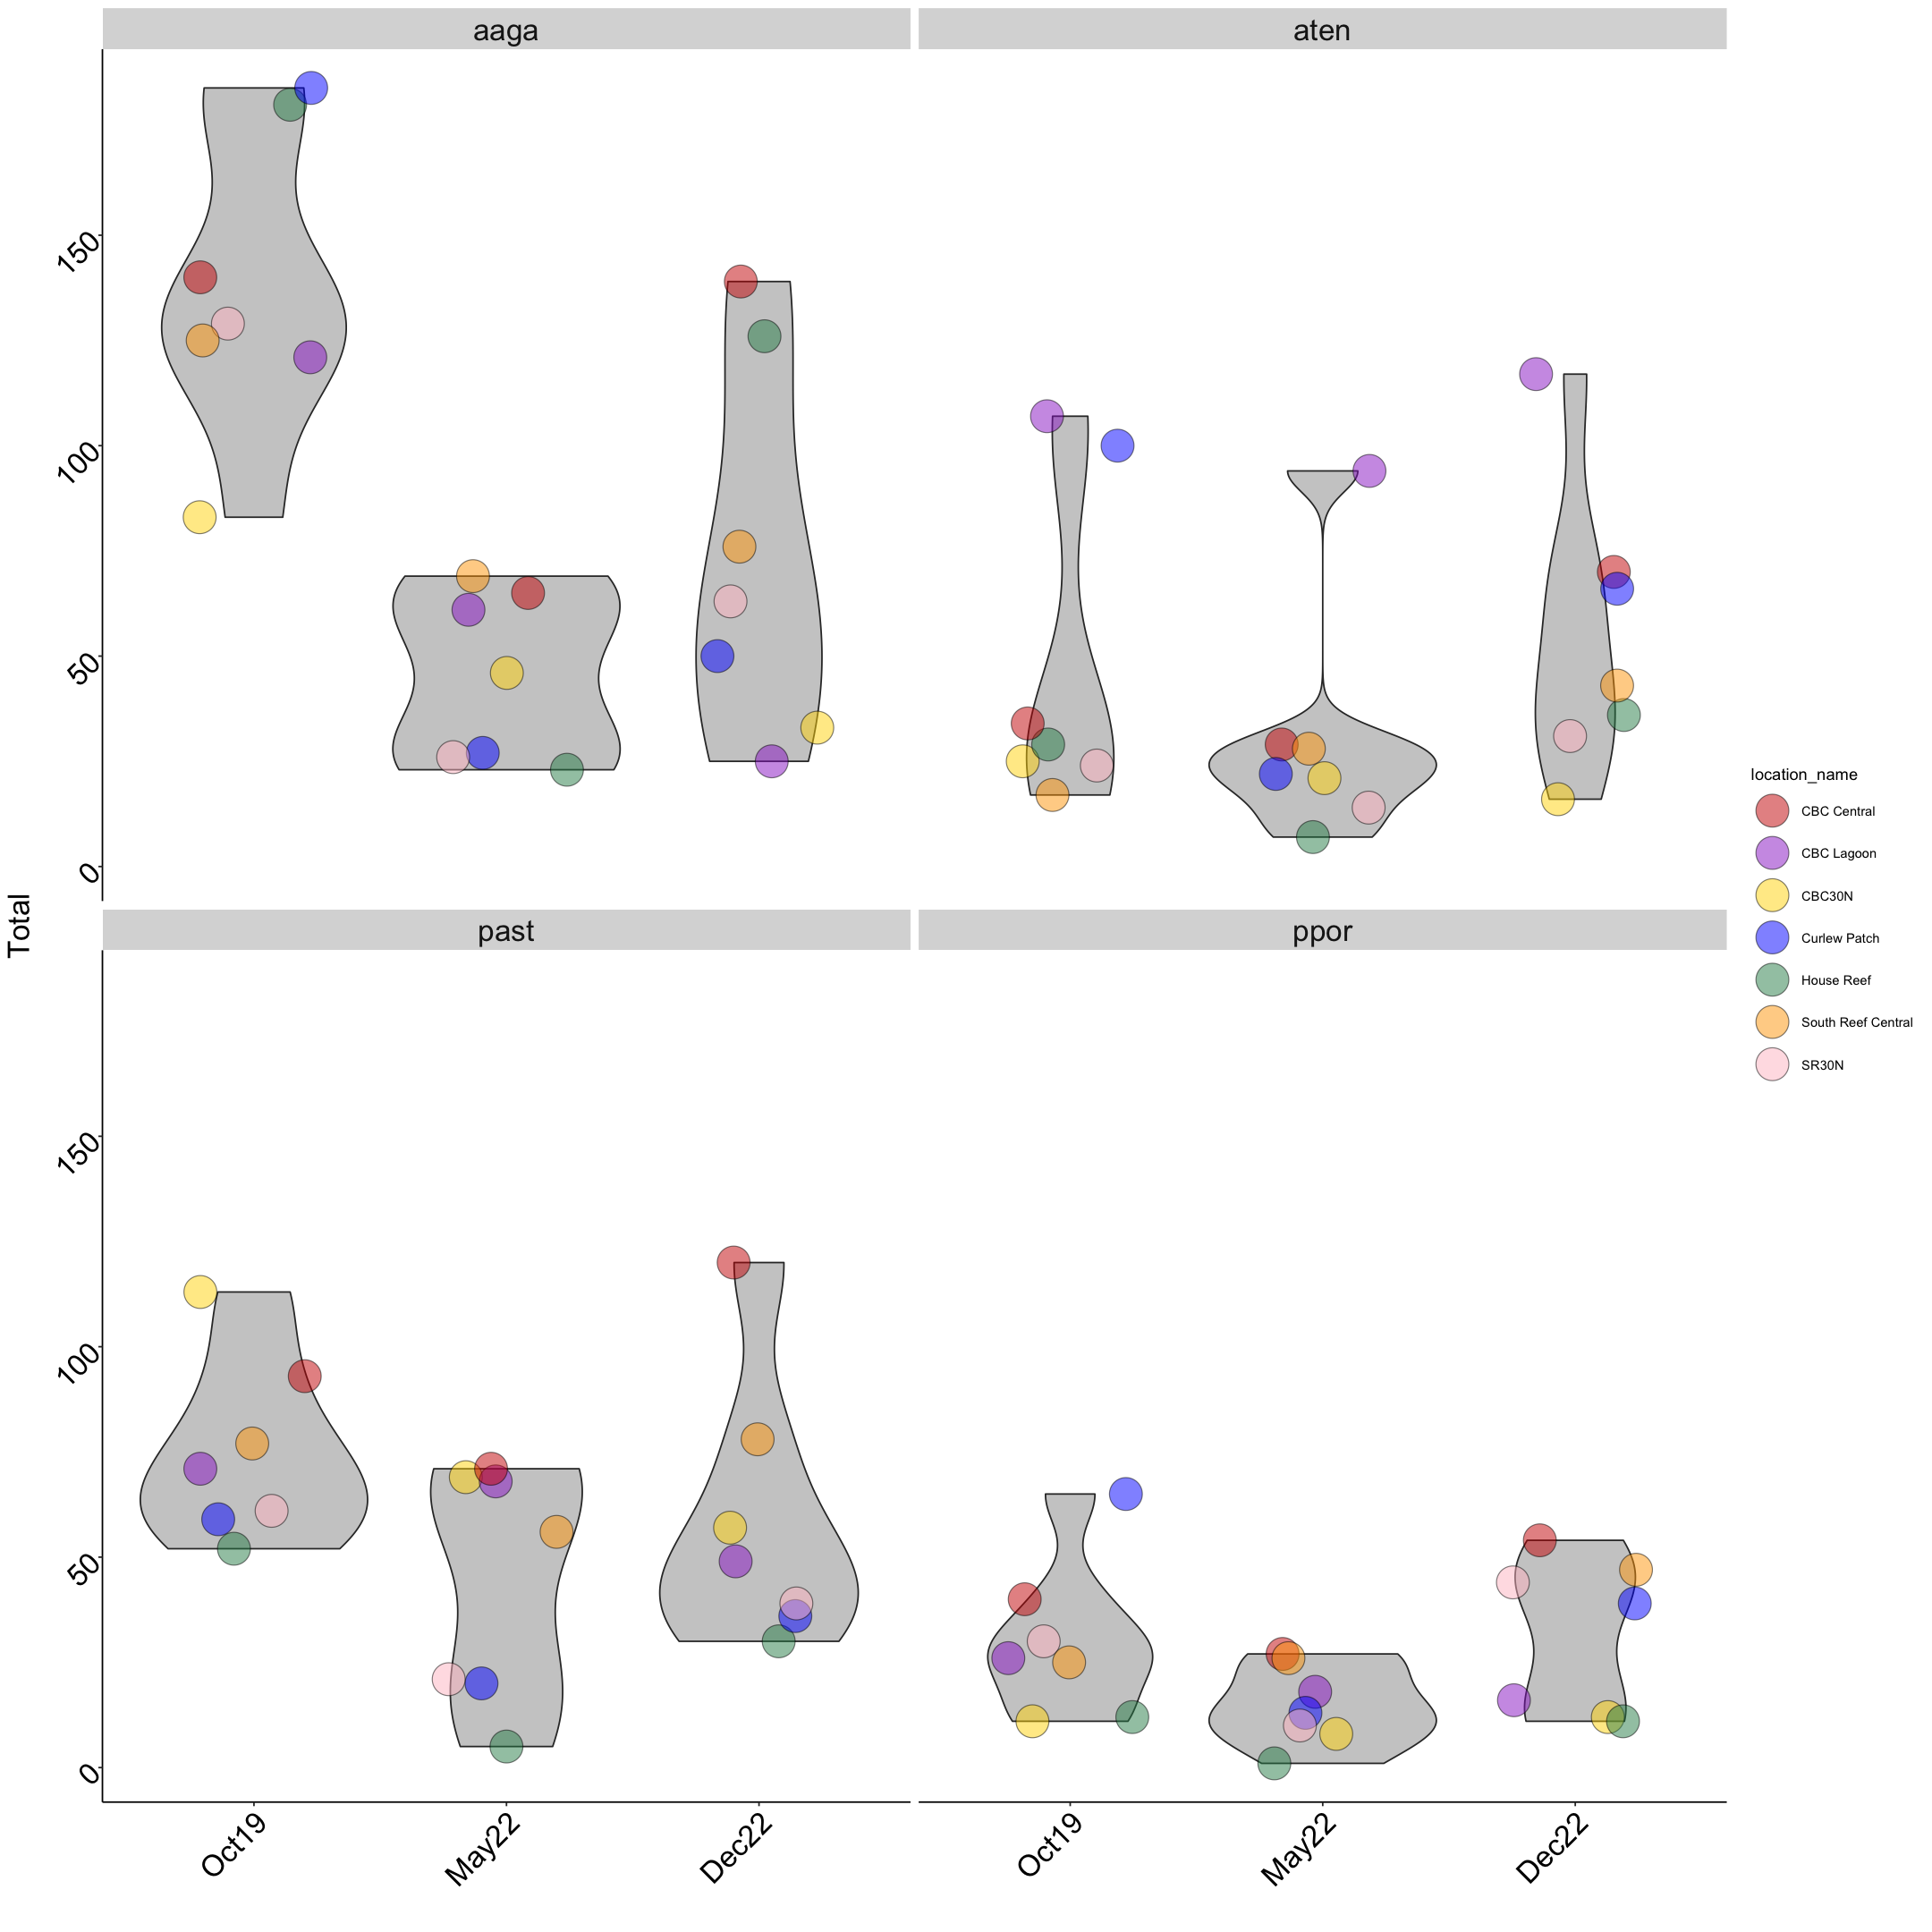

In [419]:
ggplot() +
  geom_violin(data = high, aes(x = time_point, y = Total), fill = "gray80") +
  geom_jitter(data = high, aes(x = time_point, y = Total, fill = location_name), size = 10, pch = 21, alpha=0.5,  
              width = 0.25, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code, ncol = 2) +
  #scale_y_continuous("Mean Density/m2") +
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))

In [420]:
med=demoSCTLD[demoSCTLD$code %in% c( "orbi", "ssid", "srad"),]

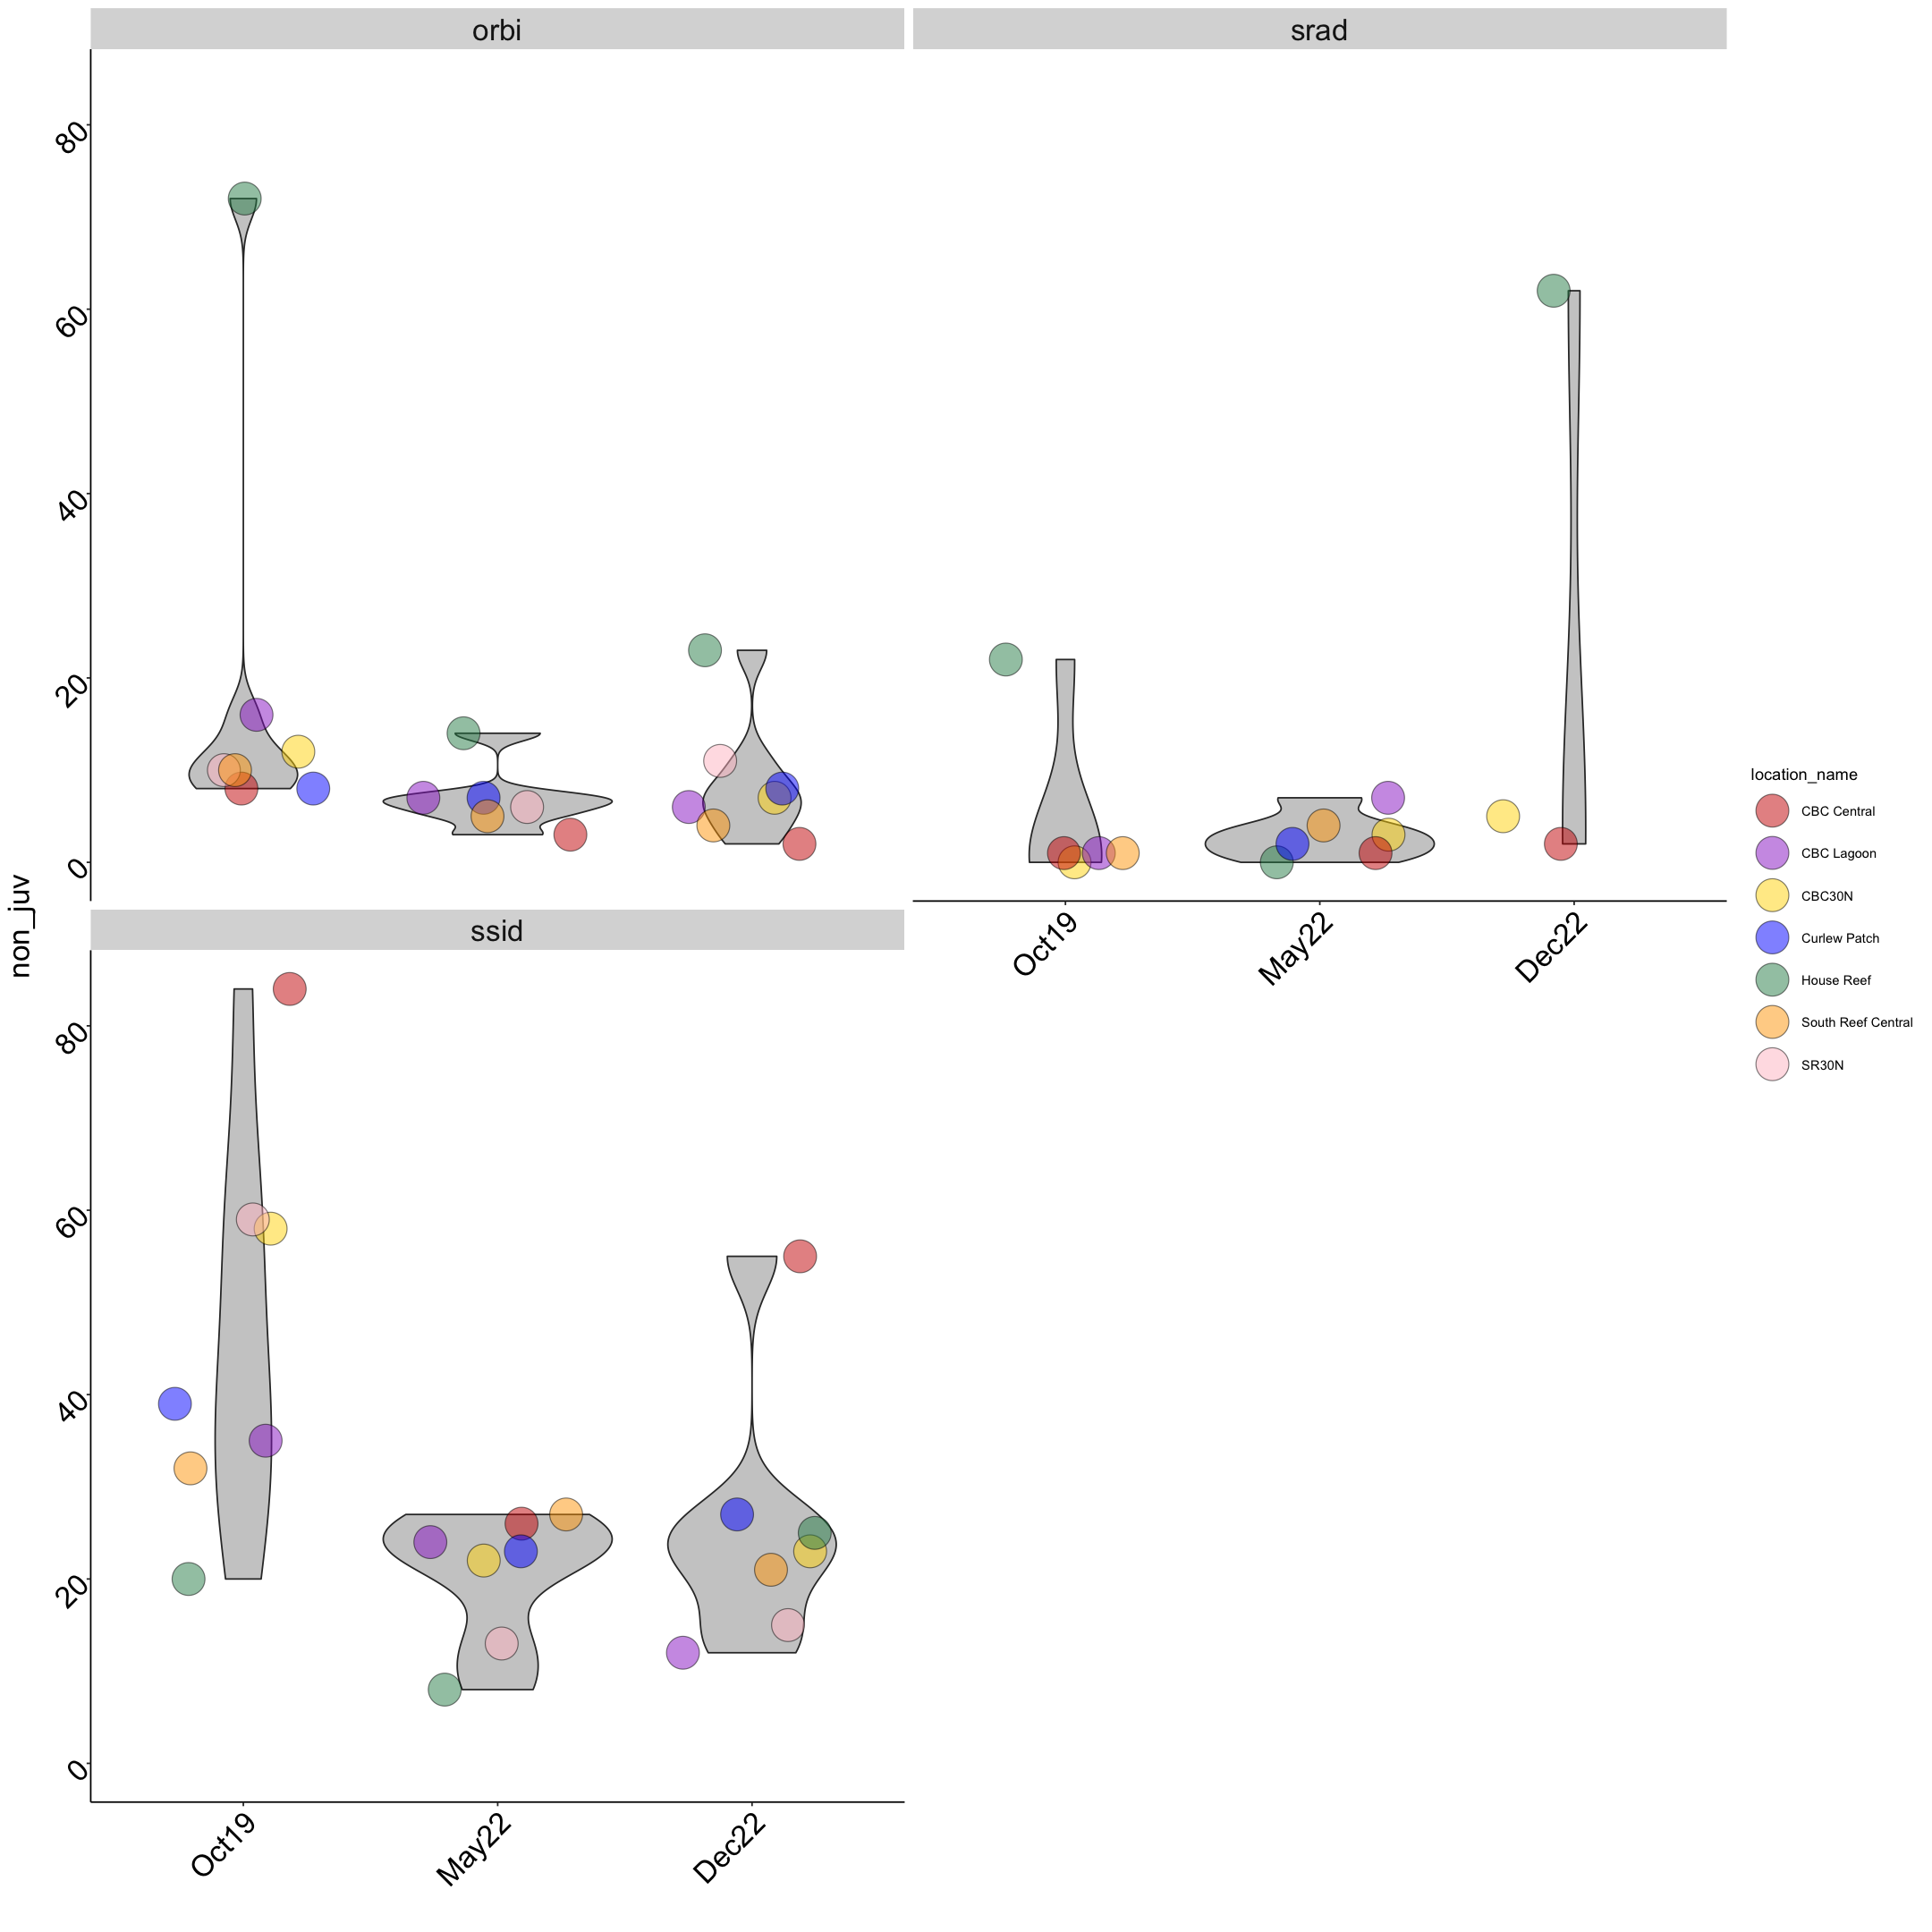

In [421]:
ggplot() +
  geom_violin(data = med, aes(x = time_point, y = non_juv), fill = "gray80") +
  geom_jitter(data = med, aes(x = time_point, y = non_juv, fill = location_name), size = 10, pch = 21, alpha=0.5,  
              width = 0.3, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code, ncol = 2) +
  #scale_y_continuous("Mean Density/m2") +
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))

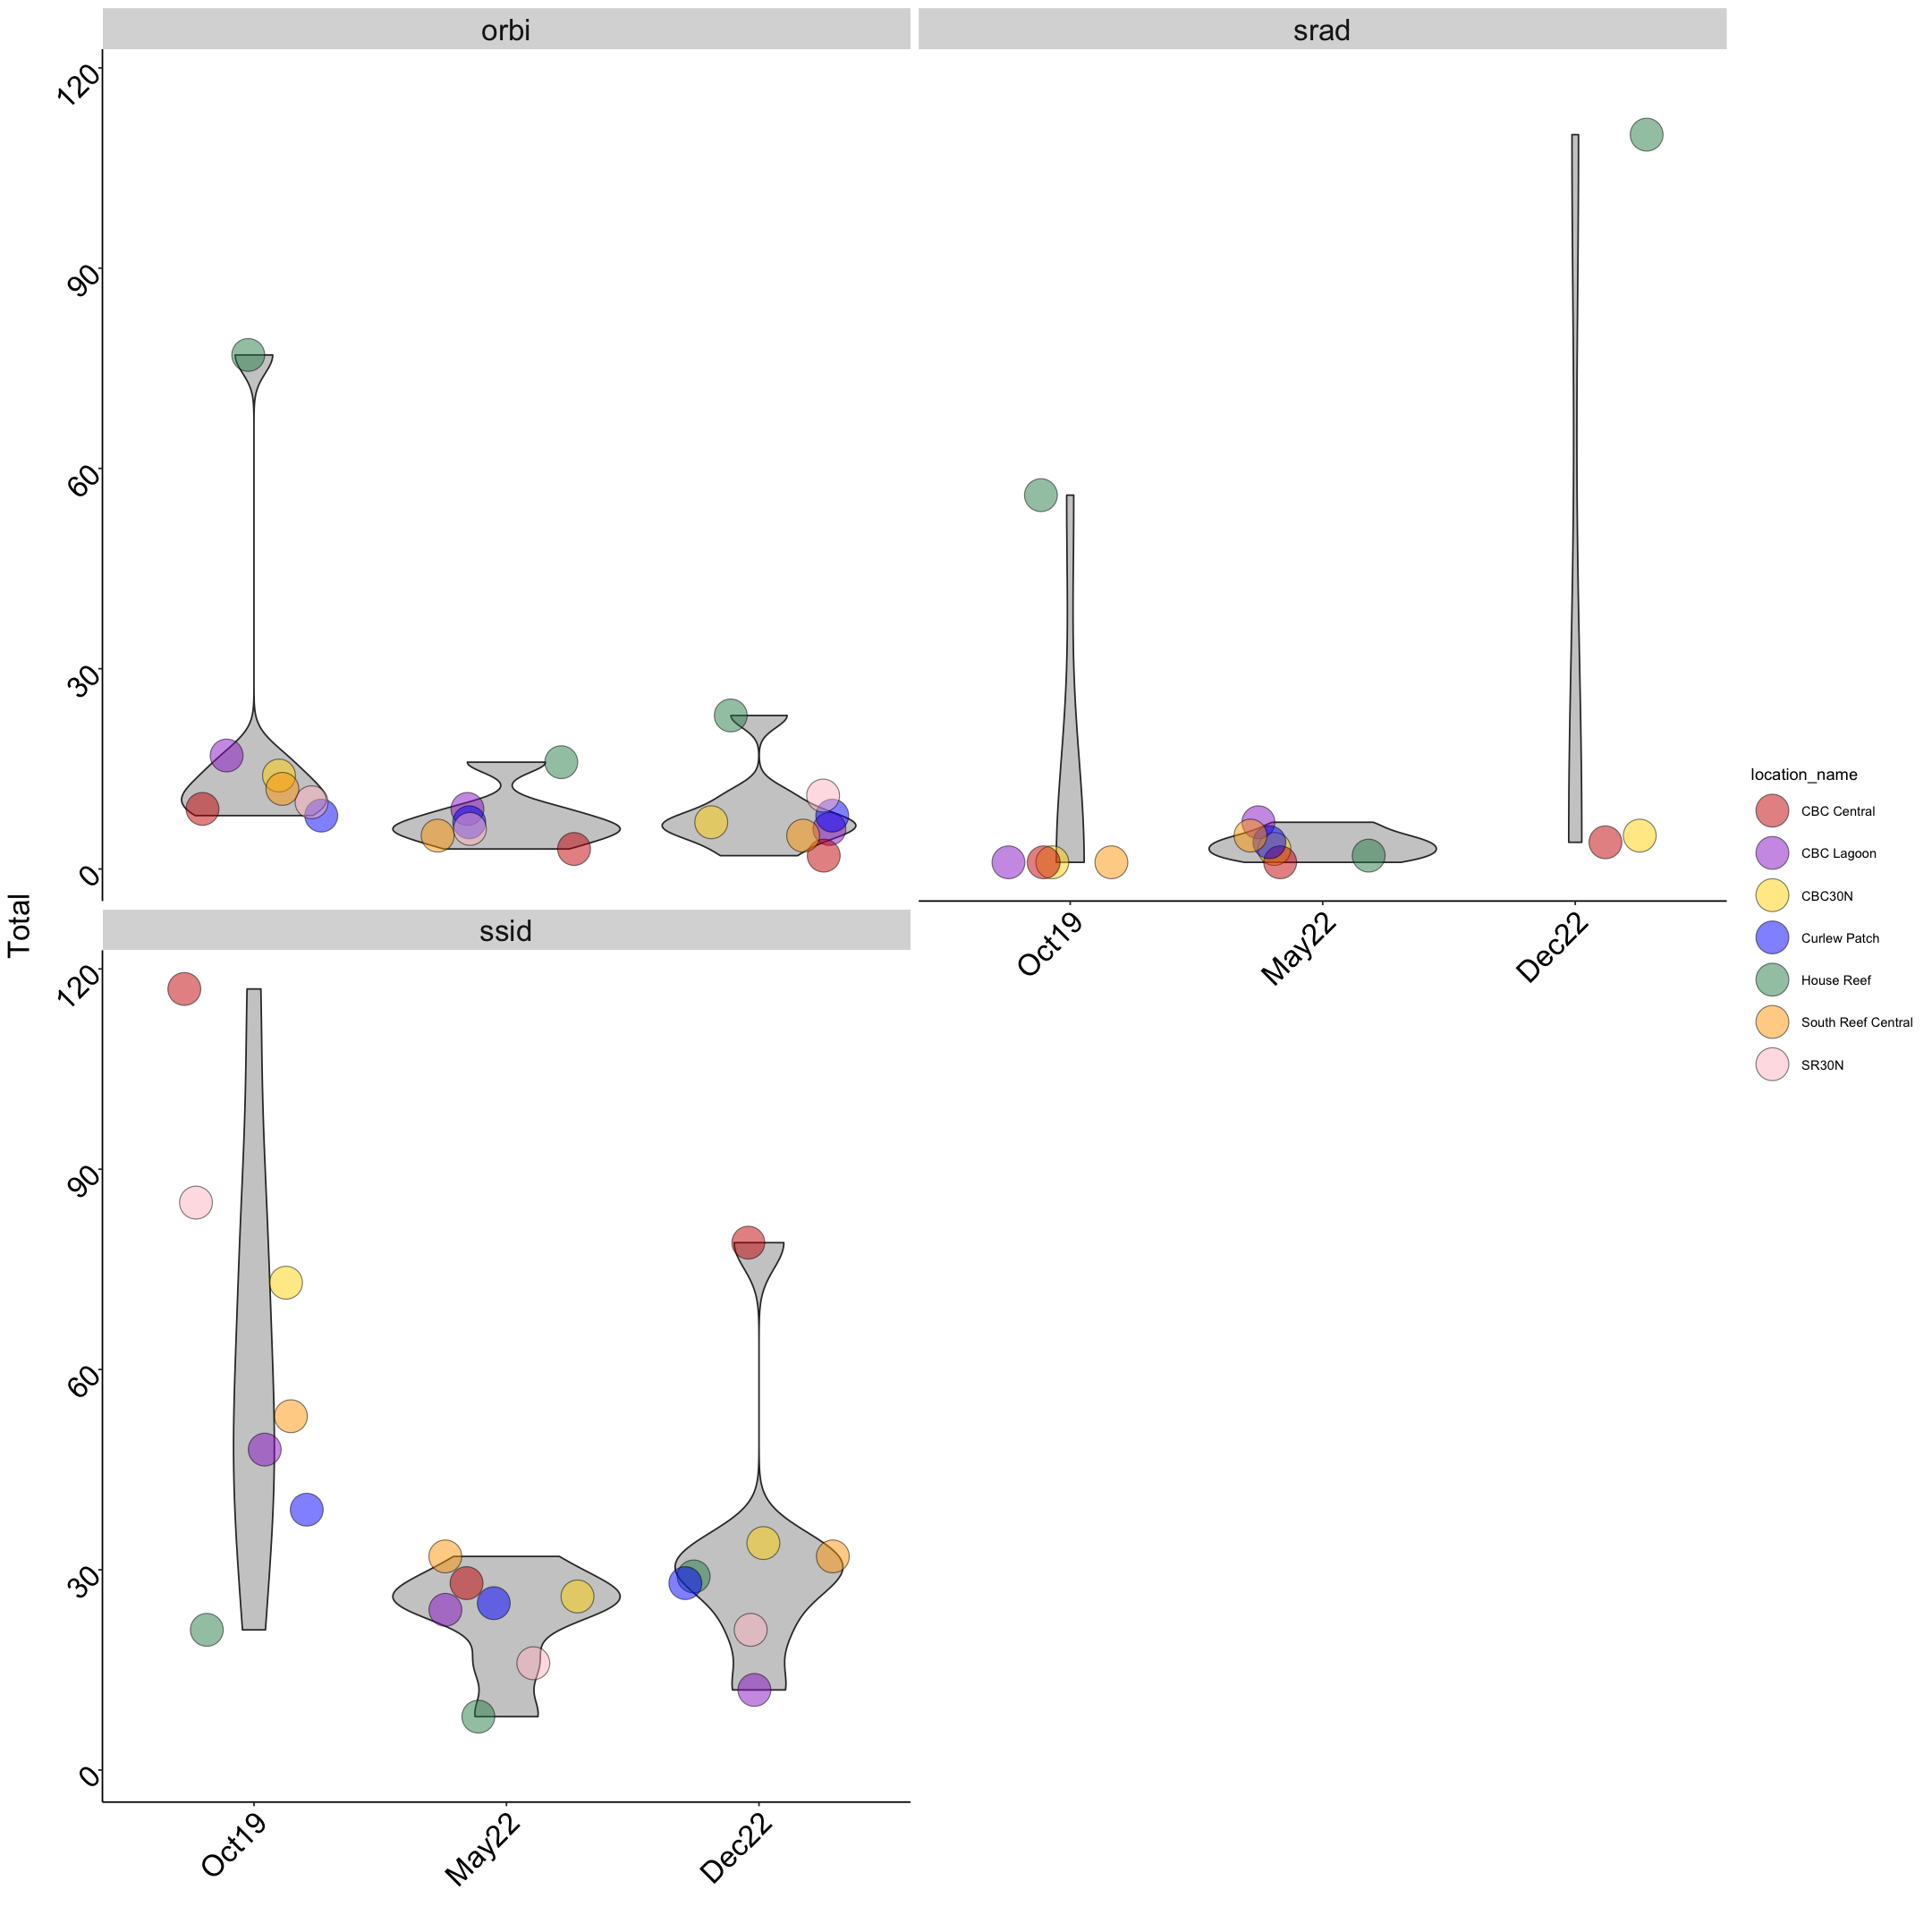

In [423]:
ggplot() +
  geom_violin(data = med, aes(x = time_point, y = Total), fill = "gray80") +
  geom_jitter(data = med, aes(x = time_point, y = Total, fill = location_name), size = 10, pch = 21, alpha=0.5,  
              width = 0.3, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code, ncol = 2) +
  #scale_y_continuous("Mean Density/m2") +
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))

In [424]:
low=demoSCTLD[demoSCTLD$code %in% c("dlab", "pstr", "mcav", "sint", "efas", "mmea", "dsto"),]

Warning message:
“Cannot compute density for groups with fewer than two datapoints.”
Warning message:
“Cannot compute density for groups with fewer than two datapoints.”


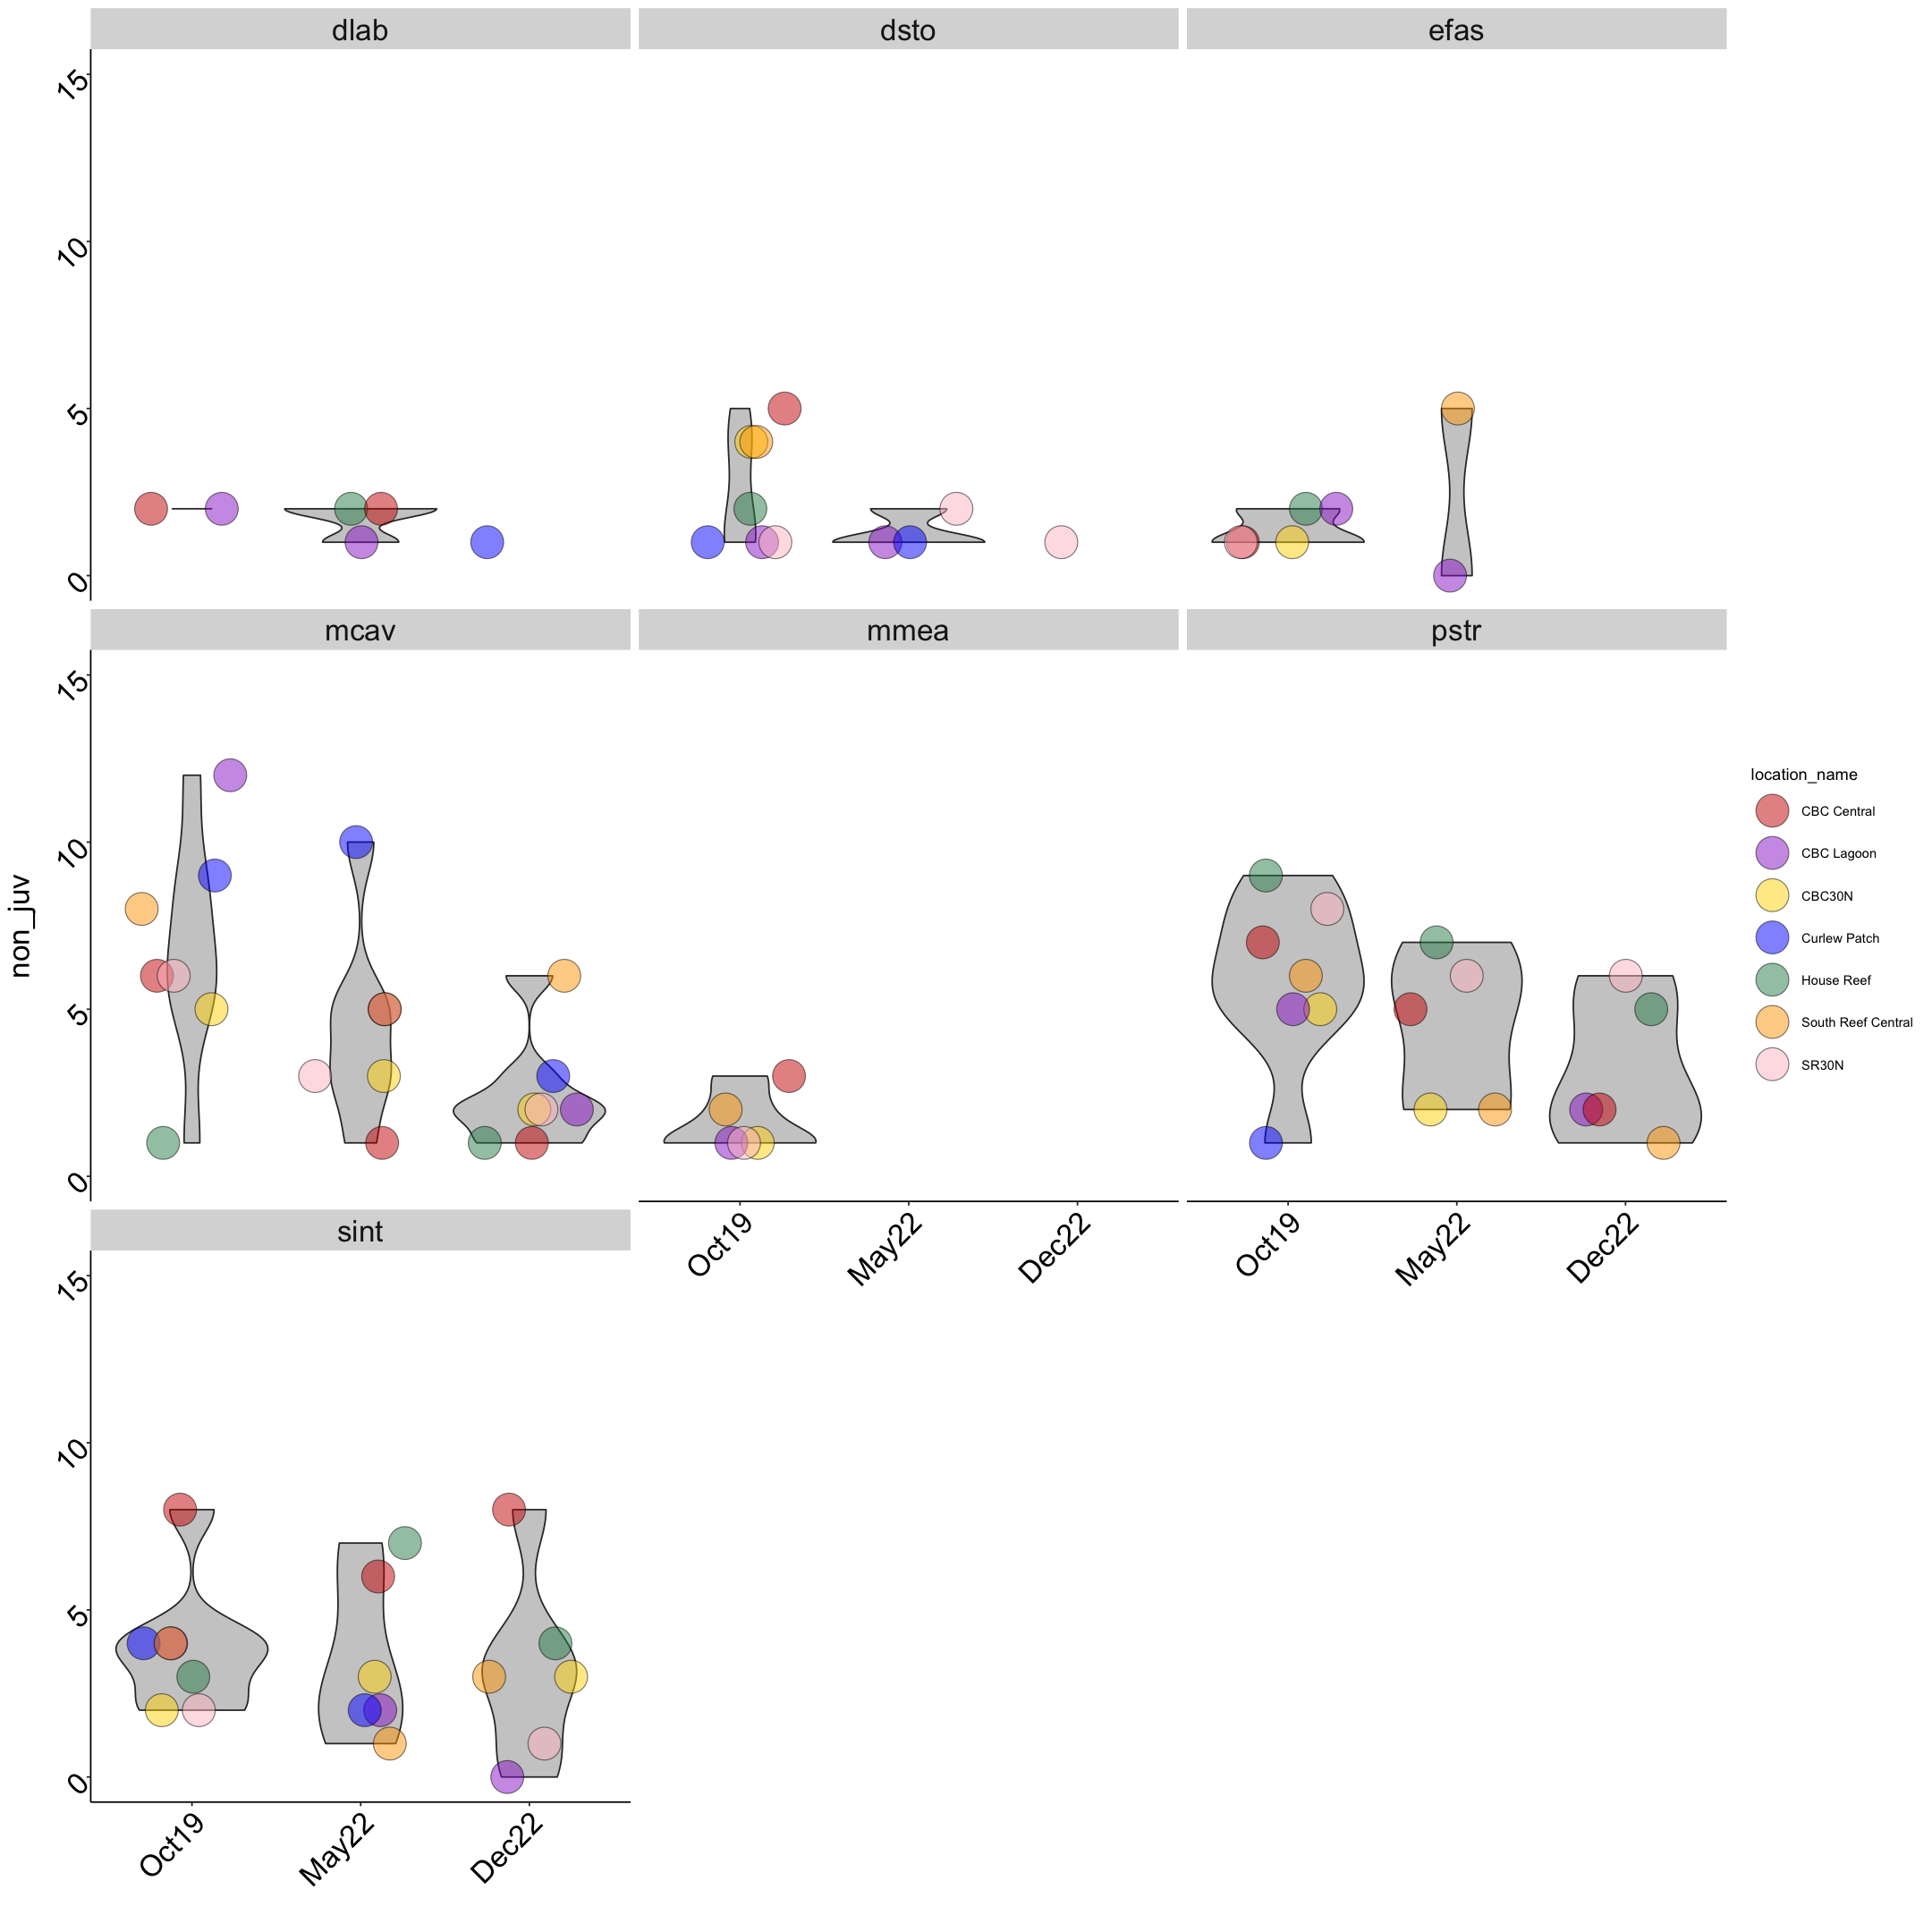

In [427]:
ggplot() +
  geom_violin(data = low, aes(x = time_point, y = non_juv), fill = "gray80", drop=FALSE) +
  geom_jitter(data = low, aes(x = time_point, y = non_juv, fill = location_name), size = 10, pch = 21, alpha=0.5,  
              width = 0.3, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code, ncol = 3) +
 # scale_y_continuous("colonies/30m2") +
ylim(0,15)+
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))

Warning message:
“Cannot compute density for groups with fewer than two datapoints.”
Warning message:
“Cannot compute density for groups with fewer than two datapoints.”


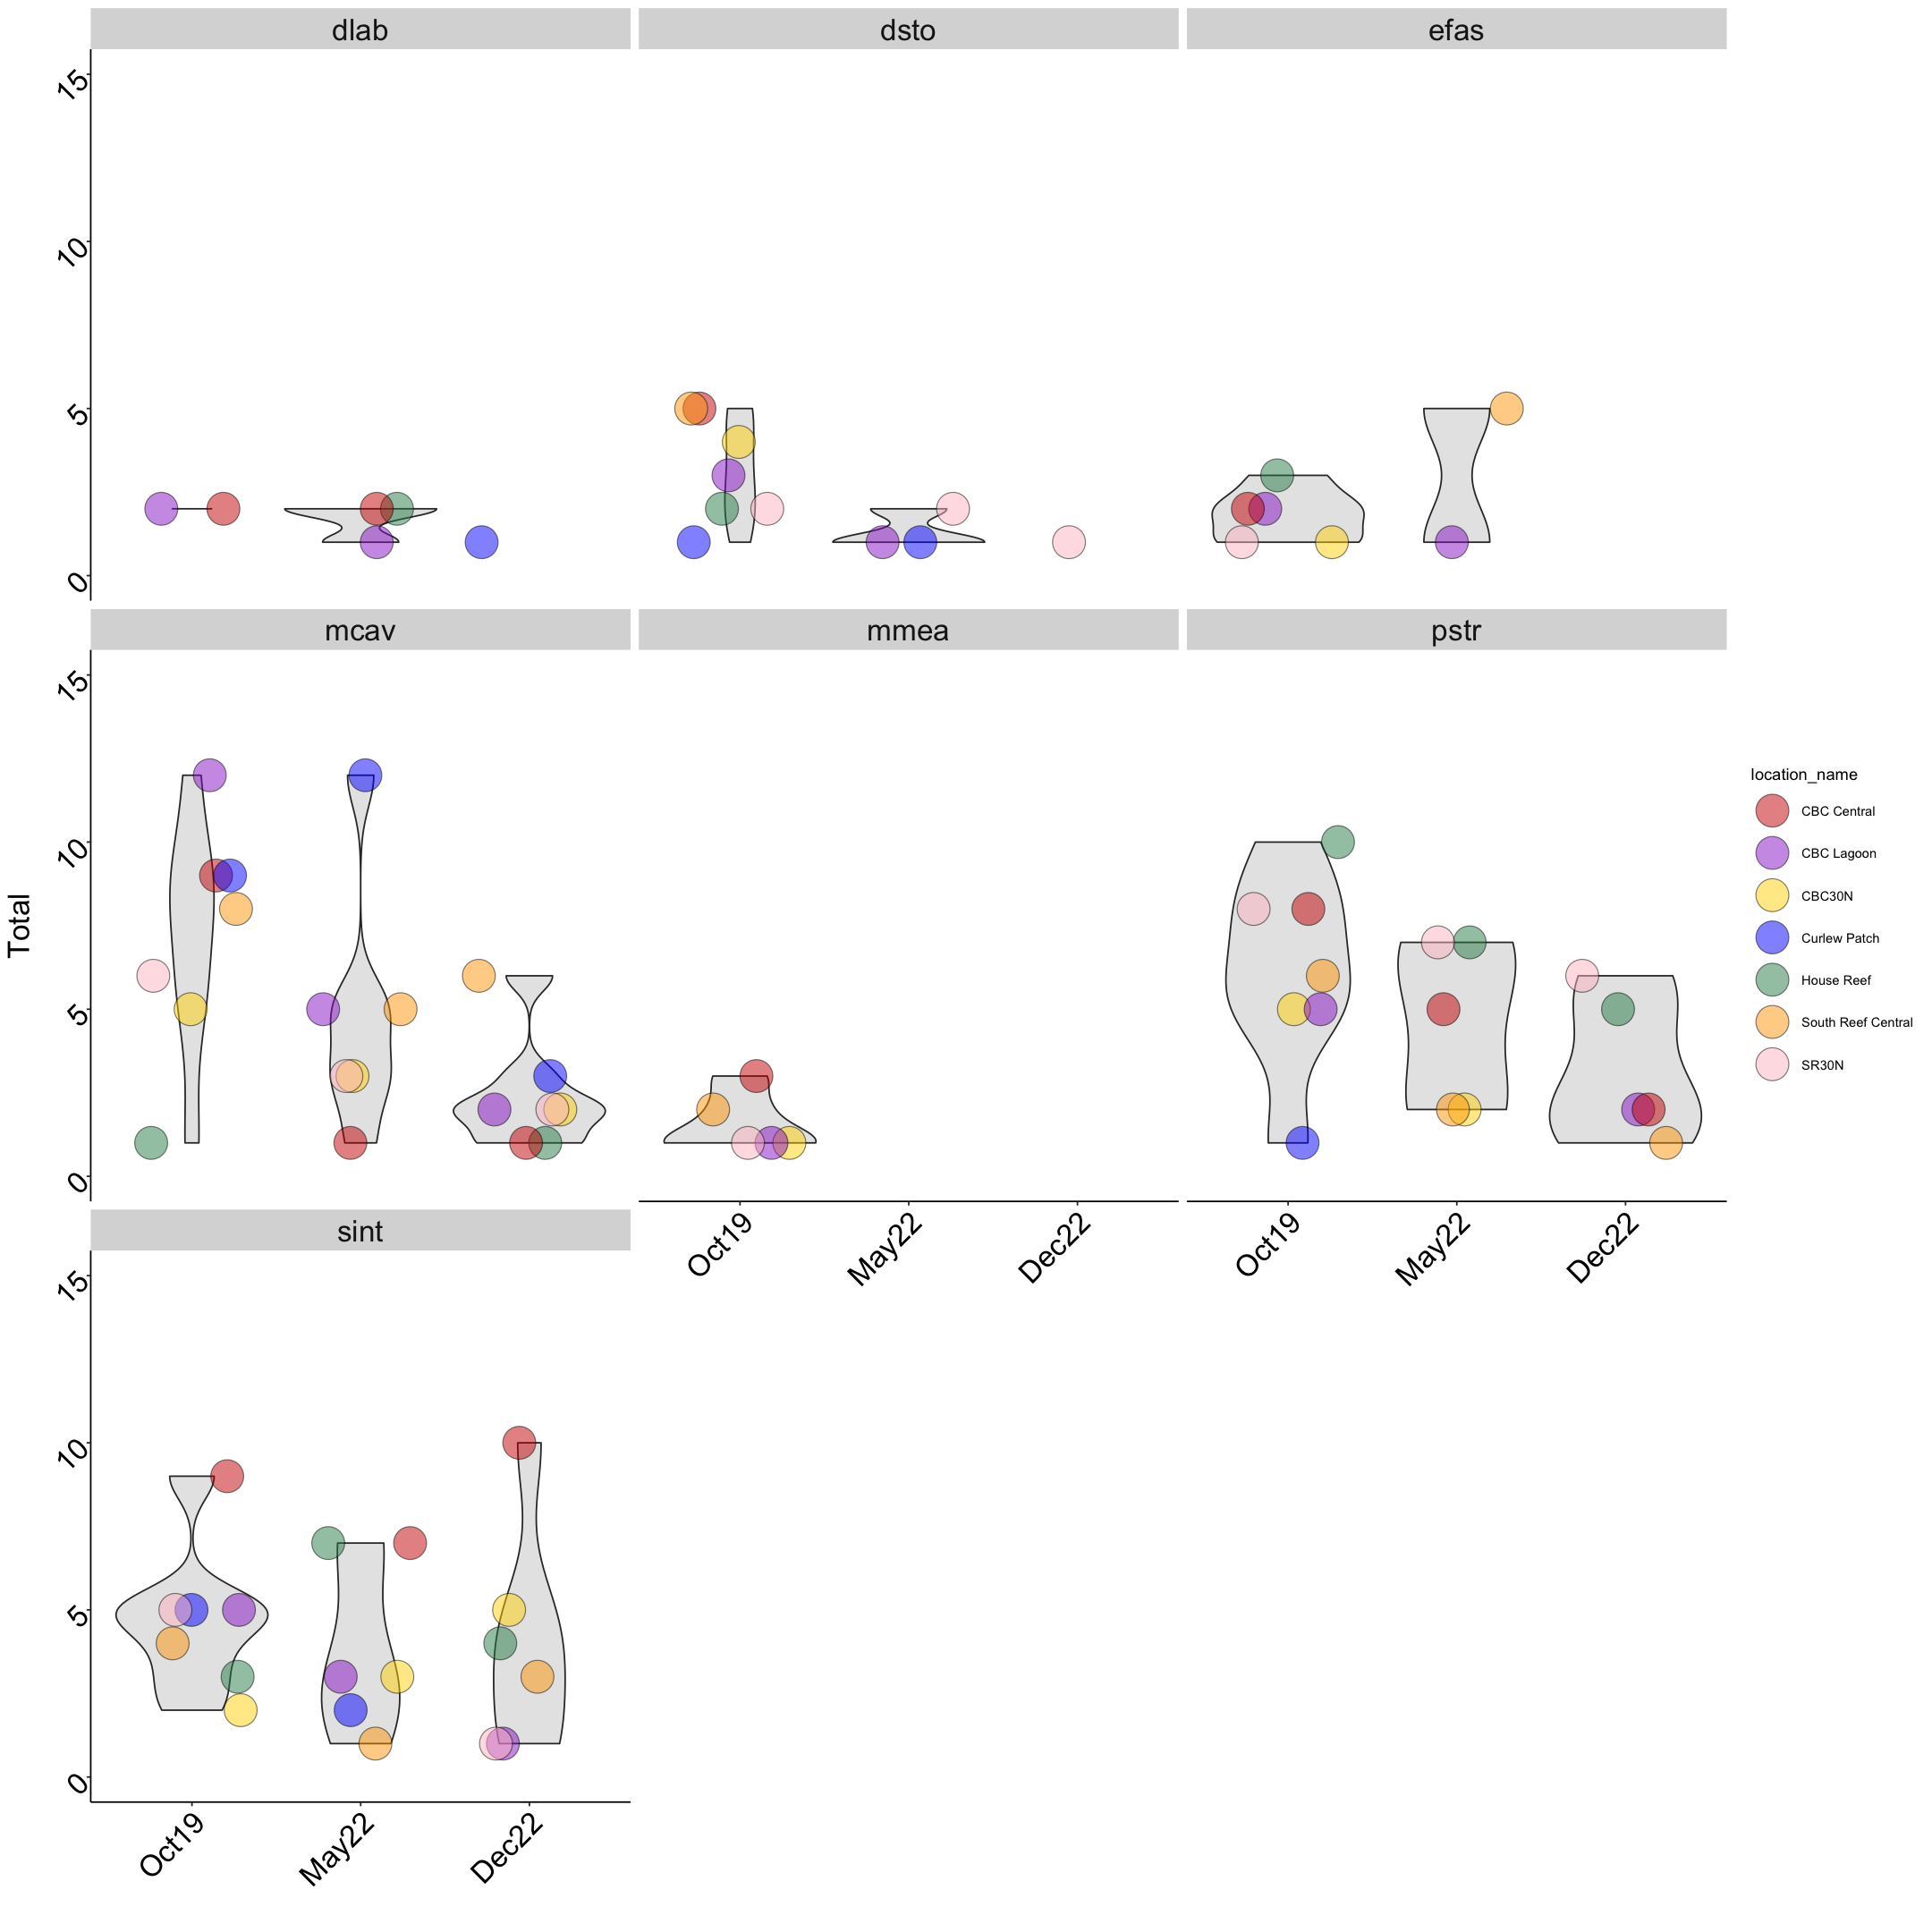

In [456]:
ggplot() +
  geom_violin(data = low, aes(x = time_point, y = Total), fill = "gray80", drop=FALSE, alpha=0.5) +
  geom_jitter(data = low, aes(x = time_point, y = Total, fill = location_name), size = 10, pch = 21, alpha=0.5,  
              width = 0.3, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code, ncol = 3) +
 # scale_y_continuous("colonies/30m2") +
ylim(0,15)+
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))

Warning message:
“Cannot compute density for groups with fewer than two datapoints.”
Warning message:
“Cannot compute density for groups with fewer than two datapoints.”


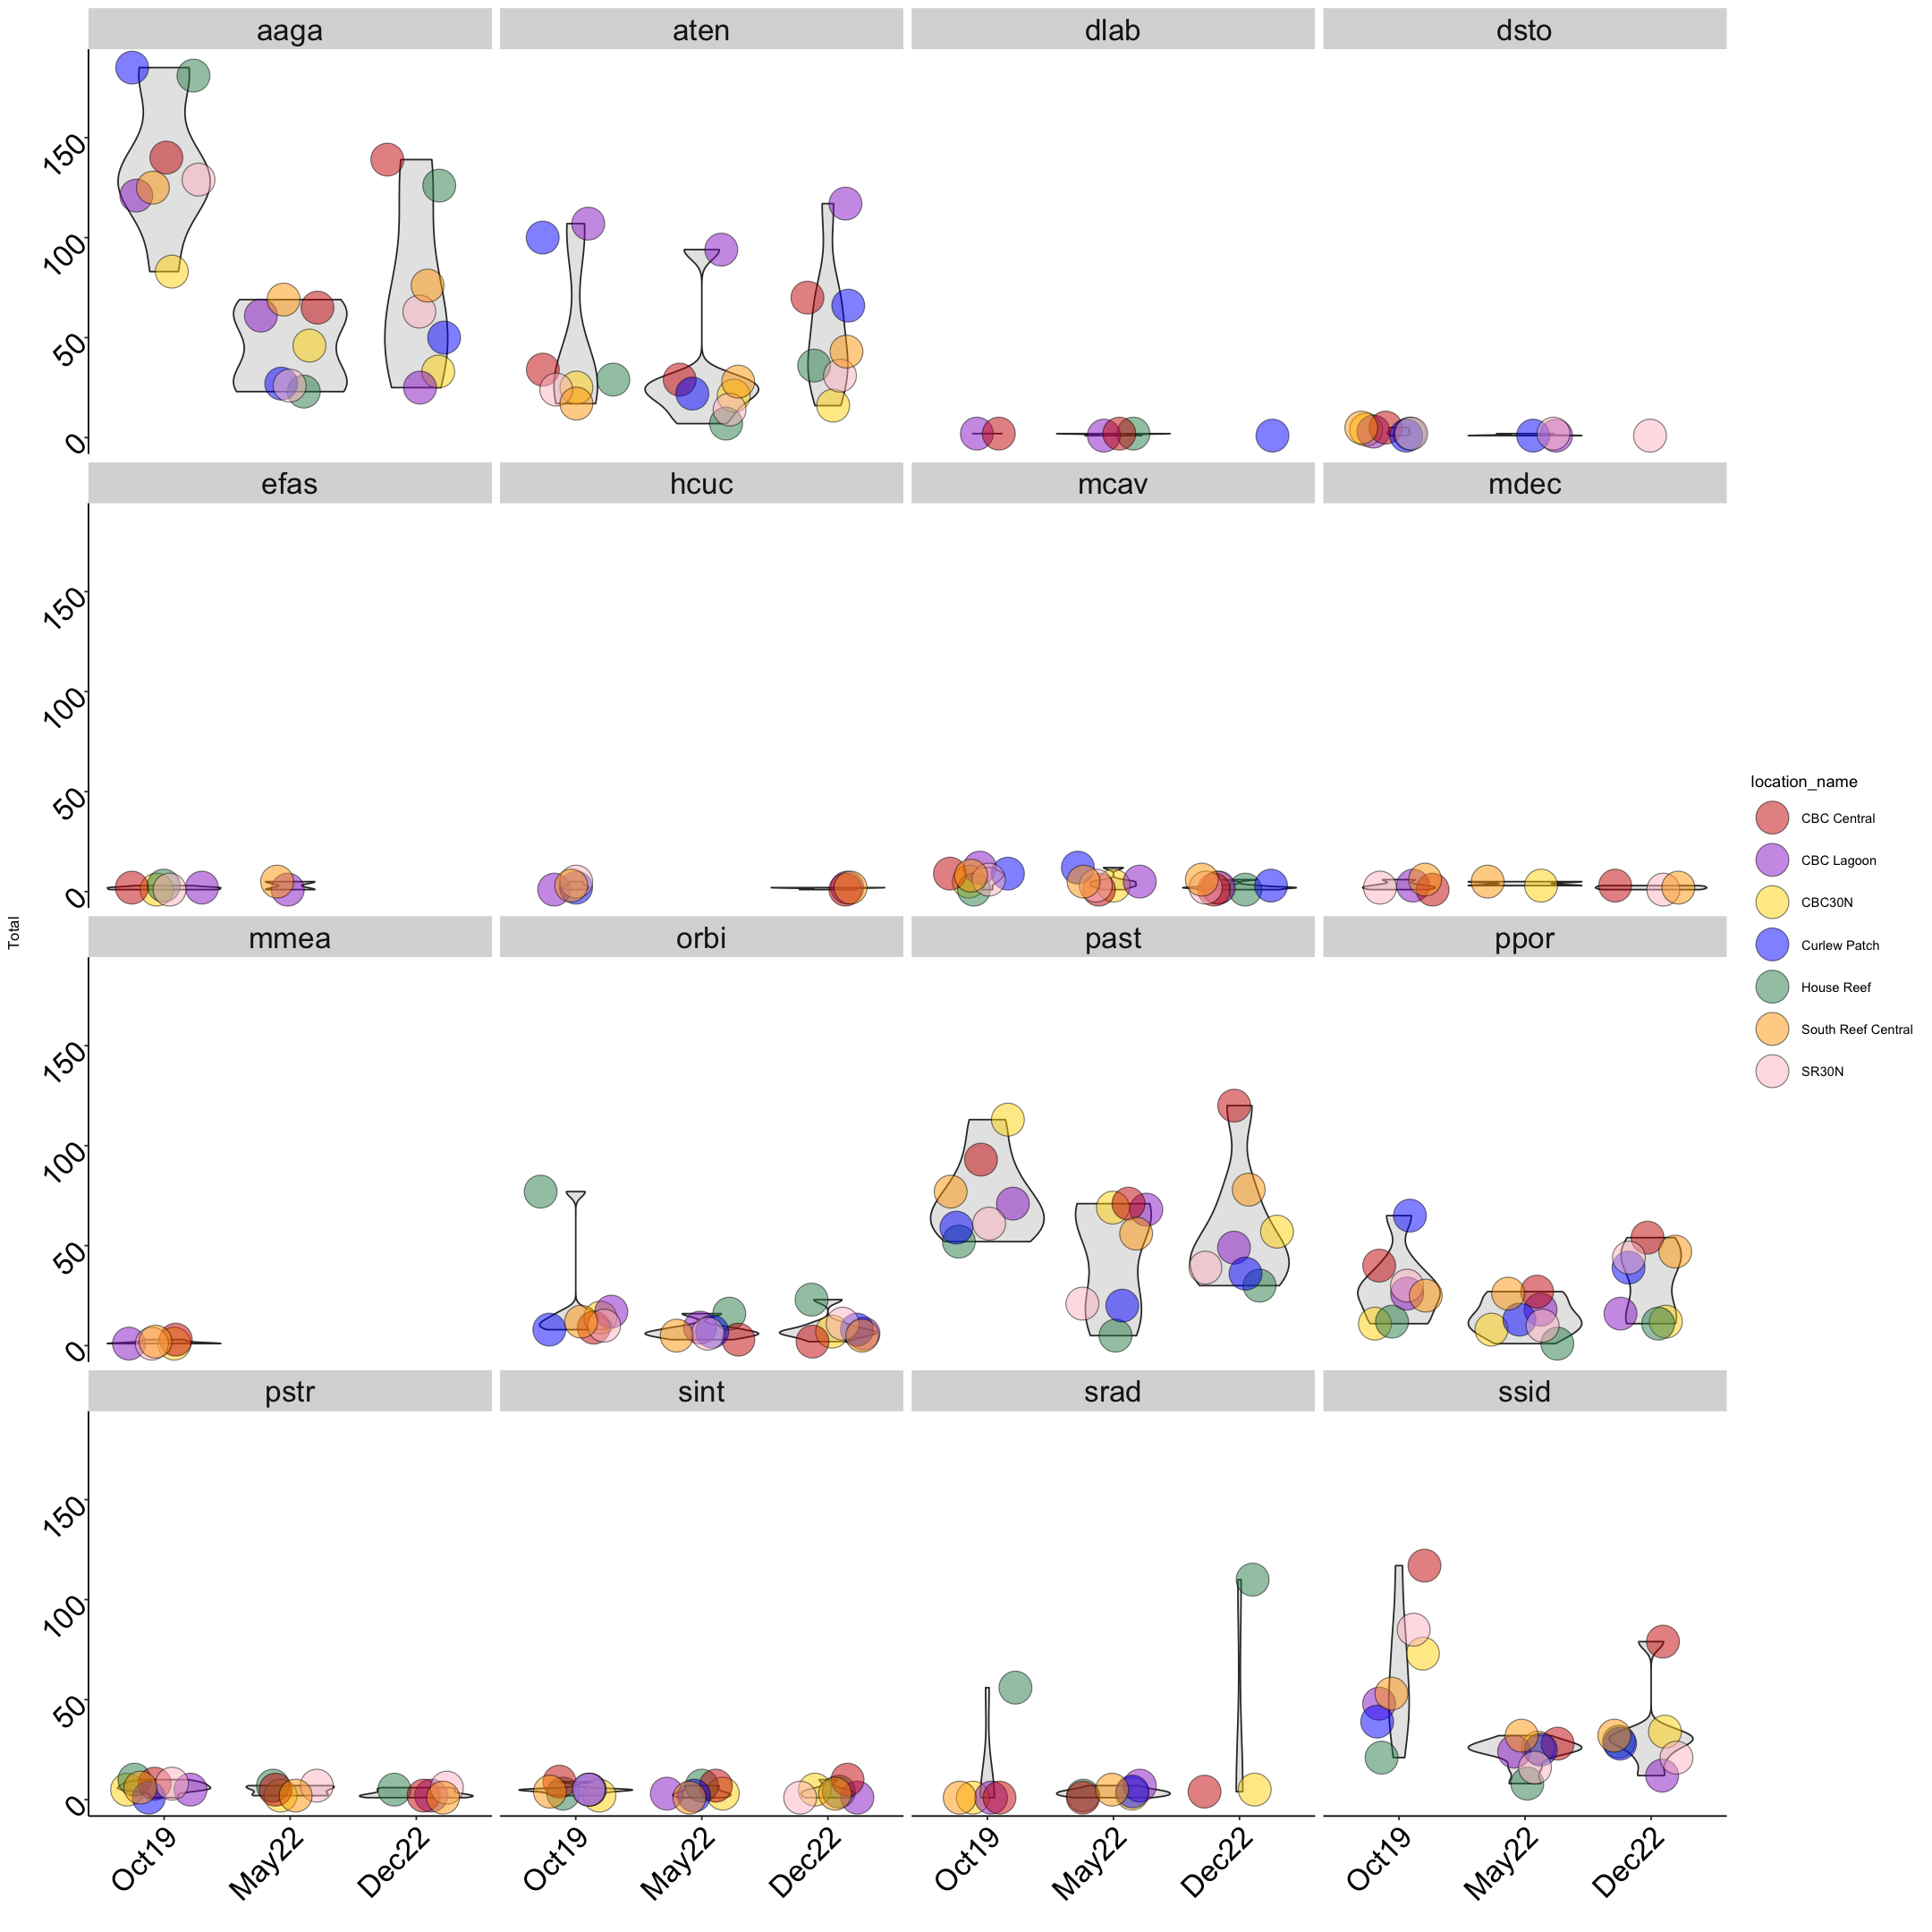

In [460]:
 ggplot() +
  geom_violin(data = demoSCTLD[!demoSCTLD$code %in% exclude,], aes(x = time_point, y = Total), fill = "gray80", alpha=0.5, drop=FALSE) +
  geom_jitter(data = demoSCTLD[!demoSCTLD$code %in% exclude,], aes(x = time_point, y = Total, fill = location_name),  alpha=0.5, size = 10, pch = 21,  
              width = 0.3, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code, ncol = 4) +
  #scale_y_continuous("Mean Density/m2") +
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 16,hjust = 0.5),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        strip.text = element_text(size = 20),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 10))

In [432]:
cond=read.csv(file="/Users/sarah/Documents/SCTLD/SCTLD_samples/Survey_Data/CBC_Coral_Conditions.csv")

In [433]:
colnames(cond)

[1] "ID"                    "diver"                 "buddy"                
 [4] "site_code"             "location_name"         "latitude"             
 [7] "longitude"             "day"                   "month"                
[10] "year"                  "depth"                 "code"                 
[13] "scientific_name"       "max_diameter"          "max_height"           
[16] "percent_mortality"     "condition_code"        "percent_affected"     
[19] "distribution"          "rate_tissue_loss"      "coral_condition_notes"
[22] "Count"

In [434]:
levels(as.factor(cond$location_name))

cond$location_name <- recode(cond$location_name,
                             "CBC 30 C" = "CBC Central",
                             "CBC 30 N" = "CBC30N",
                             "CBC 30 North" = "CBC30N",
                             "CBC House Reef" = "House Reef",
                             "CBC Lagoon Reef" = "CBC Lagoon",
                             "CBC Reef Central" = "CBC Central",
                             "South Reef 30 C" = "South Reef Central",
                             "South Reef 30 Central" = "South Reef Central",
                             "South Reef 30 North" = "SR30N")


[1] "Bread and Butter Patch" "CBC 15 South"           "CBC 30 North"          
 [4] "CBC Central"            "CBC House Reef"         "CBC Lagoon"            
 [7] "CBC Lagoon Reef"        "CBC Reef Central"       "CBC30N"                
[10] "Curlew Patch"           "Curlew Patch Reef"      "Hangman "              
[13] "House Reef"             "South Reef 15 South"    "South Reef 30 North"   
[16] "South Reef 30 South"    "South Reef Central"     "SR30N"                 
[19] "Tobacco Reef"

In [435]:
cond <- cond %>% mutate(time_point = "x") %>%
  mutate(time_point = case_when(
    year == "2019"|year == "2020" ~ "Oct19",
    TRUE ~ as.character(time_point))) %>% 
  mutate(time_point = case_when(
    year == "2022" & month == "5" ~ "May22",
    TRUE ~ as.character(time_point))) %>% 
  mutate(time_point = case_when(
    year == "2022" & month == "12" ~ "Dec22",
    TRUE ~ as.character(time_point)))

In [436]:
cond$condition_code <- recode(cond$condition_code, "CLP;CLB" = "CLP/CLB")

cond <- cond %>% subset(condition_code != "")

cond$condition_code_a <- cond$condition_code

In [437]:
cond2 <- cond %>% separate_wider_delim(condition_code_a, "/", names = c("cond_1", "cond_2", "cond3"),
                                       too_few = "align_start")

In [438]:
cond3 <- cond2 %>% mutate(percent_affected = ifelse(percent_affected == 1,
                                                    "A", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 10,
                                   "B", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 15,
                                   "B", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 20,
                                   "B", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 25,
                                   "B", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 30,
                                   "B", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 5,
                                   "A", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 50,
                                   "B", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 60,
                                   "C", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 70,
                                   "C", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 75,
                                   "C", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 80,
                                   "C", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 85,
                                   "C", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 90,
                                   "C", percent_affected)) %>%
  mutate(percent_affected = ifelse(percent_affected == 95,
                                   "C", percent_affected))

In [439]:
cond3$percent_affected <- gsub(";", "/", cond3$percent_affected)

cond3$percent_affected_a <- cond3$percent_affected

cond4 <- cond3 %>% separate_wider_delim(percent_affected_a, "/", names = c("perc_1", "perc_2"),
                                        too_few = "align_start")


In [440]:
levels(as.factor(cond4$distribution))

cond4$distribution <- gsub(";", "/", cond4$distribution)

pr <- cond4 %>% subset(distribution == "P"|distribution == "R"|distribution == "DA")

cond4$distribution <- recode(cond4$distribution,
                             "R" = "F",
                             "P" = "D", 
                             "DA" = "D")


[1] ""      "A"     "B"     "B/B"   "C"     "d"     "D"     "D, F"  "d,d"  
[10] "D,D"   "d,f"   "D,F"   "D;F"   "d.d"   "d/d"   "D/D"   "d/f"   "D/F"  
[19] "D/MF"  "D/W"   "DA"    "f"     "F"     "f,d"   "F/D"   "F/MF"  "mf"   
[28] "MF"    "mf,d"  "MF,F"  "mf,mf" "MF/D"  "MF/F"  "MF/MF" "P"     "R"    
[37] "TD"    "w"     "W"     "w,f"   "w,mf"  "w.mf"  "W/D"   "w/mf"  "W/MF"

In [441]:
cond4$distribution_a <- cond4$distribution

cond4 <- cond4 %>% separate_wider_delim(distribution_a, "/", names = c("dist_1", "dist_2"),
                                        too_few = "align_start")

levels(as.factor(cond4$rate_tissue_loss))

tl <- cond4 %>% subset(rate_tissue_loss == "C"|rate_tissue_loss == "SA,A")


cond4$rate_tissue_loss <- recode(cond4$rate_tissue_loss,
                                 "C" = "SA")

cond4$rate_tissue_loss_a <- cond4$rate_tissue_loss

[1] ""     "a"    "A"    "C"    "D"    "N/A"  "Old"  "sa"   "SA"   "SA,A"
[11] "sa/a" "w"

In [442]:
colnames(cond4)

[1] "ID"                    "diver"                 "buddy"                
 [4] "site_code"             "location_name"         "latitude"             
 [7] "longitude"             "day"                   "month"                
[10] "year"                  "depth"                 "code"                 
[13] "scientific_name"       "max_diameter"          "max_height"           
[16] "percent_mortality"     "condition_code"        "percent_affected"     
[19] "distribution"          "rate_tissue_loss"      "coral_condition_notes"
[22] "Count"                 "time_point"            "cond_1"               
[25] "cond_2"                "cond3"                 "perc_1"               
[28] "perc_2"                "dist_1"                "dist_2"               
[31] "rate_tissue_loss_a"

In [443]:
cond <- cond4 %>% separate_wider_delim(rate_tissue_loss_a, "/", names = c("rate_1", "rate_2"),
                                       too_few = "align_start")

sum_tl <- cond %>% subset(cond_1 == "TL" &  perc_1 != "A"| cond_2 == "TL" & perc_2 != "A"  ) %>%
  group_by(time_point, location_name, code) %>%
  summarize(n_tl = n())

`summarise()` has grouped output by 'time_point', 'location_name'. You can override using the `.groups` argument.


In [444]:
A <- cond %>% subset(perc_1 == "A")

levels(as.factor(cond$perc_1))

#sum_tl <- cond %>% subset(cond_1 == "TL"| cond_2 == "TL") %>%
  #group_by(time_point, location_name, scientific_name) %>%
  #summarize(n_tl = n()) #this makes prev plot A

sum_tl$time_point_a <- sum_tl$time_point
sum_tl$location_name_a <- sum_tl$location_name
sum_tl$scientific_name_a <- sum_tl$code

sum_tl <- sum_tl %>% unite("Event", c("time_point_a", "location_name_a", "scientific_name_a"), sep = "_")


[1] ""       "?"      "0"      "0.1"    "10,10"  "10,50"  "100"    "100,20"
 [9] "100,30" "100,40" "100,5"  "100,50" "100,6"  "100,60" "100,90" "12"    
[17] "15,40"  "20,20"  "20,80"  "25,25"  "3"      "35"     "40"     "5,10"  
[25] "5,20"   "5,30"   "50,2"   "50,20"  "80,20"  "80100"  "95,5"   "98"    
[33] "a"      "A"      "A, C"   "A, D"   "A,A"    "A,B"    "a,b,c"  "A,D"   
[41] "b"      "B"      "B, A "  "B,A"    "b,b"    "B,B"    "b,c"    "B,C"   
[49] "B,D"    "c"      "C"      "C, B"   "c,a"    "C,A"    "c,b"    "C,B"   
[57] "c,c"    "C,C"    "d"      "D"      "D, B"   "D, D"   "d,a"    "D,A"   
[65] "D,A,A"  "d,b"    "D,B"    "d,c"    "D,C"    "F"      "S"      "W"

In [445]:
head(sum_tl)

time_point location_name code n_tl Event                 
1 Dec22      CBC Central   aaga  1   Dec22_CBC Central_aaga
2 Dec22      CBC Central   aten  3   Dec22_CBC Central_aten
3 Dec22      CBC Central   ssid 19   Dec22_CBC Central_ssid
4 Dec22      CBC Lagoon    aaga  1   Dec22_CBC Lagoon_aaga 
5 Dec22      CBC Lagoon    mcav  1   Dec22_CBC Lagoon_mcav 
6 Dec22      CBC Lagoon    ssid  6   Dec22_CBC Lagoon_ssid

In [446]:
##get the demographic data ready to calculate prevalence
sum_demo <- demoSCTLD %>%
  group_by(time_point, location_name, code) %>%
  summarize(total_nj = sum(non_juv))

sum_demo$time_point_a <- sum_demo$time_point
sum_demo$location_name_a <- sum_demo$location_name
sum_demo$scientific_name_a <- sum_demo$code

sum_demo <- sum_demo %>% unite("Event", c("time_point_a", "location_name_a", "scientific_name_a"), sep = "_")


`summarise()` has grouped output by 'time_point', 'location_name'. You can override using the `.groups` argument.


In [451]:
head(tldf)

time_point.x location_name.x code.x total_nj Event                  n_tl
1 Oct19        CBC Central     aaga   115      Oct19_CBC Central_aaga 0   
2 Oct19        CBC Central     aten    34      Oct19_CBC Central_aten 0   
3 Oct19        CBC Central     dlab     2      Oct19_CBC Central_dlab 0   
4 Oct19        CBC Central     dsto     5      Oct19_CBC Central_dsto 0   
5 Oct19        CBC Central     efas     1      Oct19_CBC Central_efas 0   
6 Oct19        CBC Central     mcav     6      Oct19_CBC Central_mcav 0   
  prev_tl
1 0      
2 0      
3 0      
4 0      
5 0      
6 0

In [448]:
#create dataframe for tissue loss calculate prevalence
tldf <- sum_demo %>% left_join(sum_tl, by = "Event") %>% 
  dplyr::select(-c(time_point.y:code.y)) %>%
  replace(is.na(.), 0) %>%
  mutate(prev_tl = n_tl/total_nj)

In [449]:
## remove any that had 0 corals
tldf <- na.omit(tldf)

Warning message:
“Cannot compute density for groups with fewer than two datapoints.”
Warning message:
“Cannot compute density for groups with fewer than two datapoints.”
Warning message:
“Cannot compute density for groups with fewer than two datapoints.”


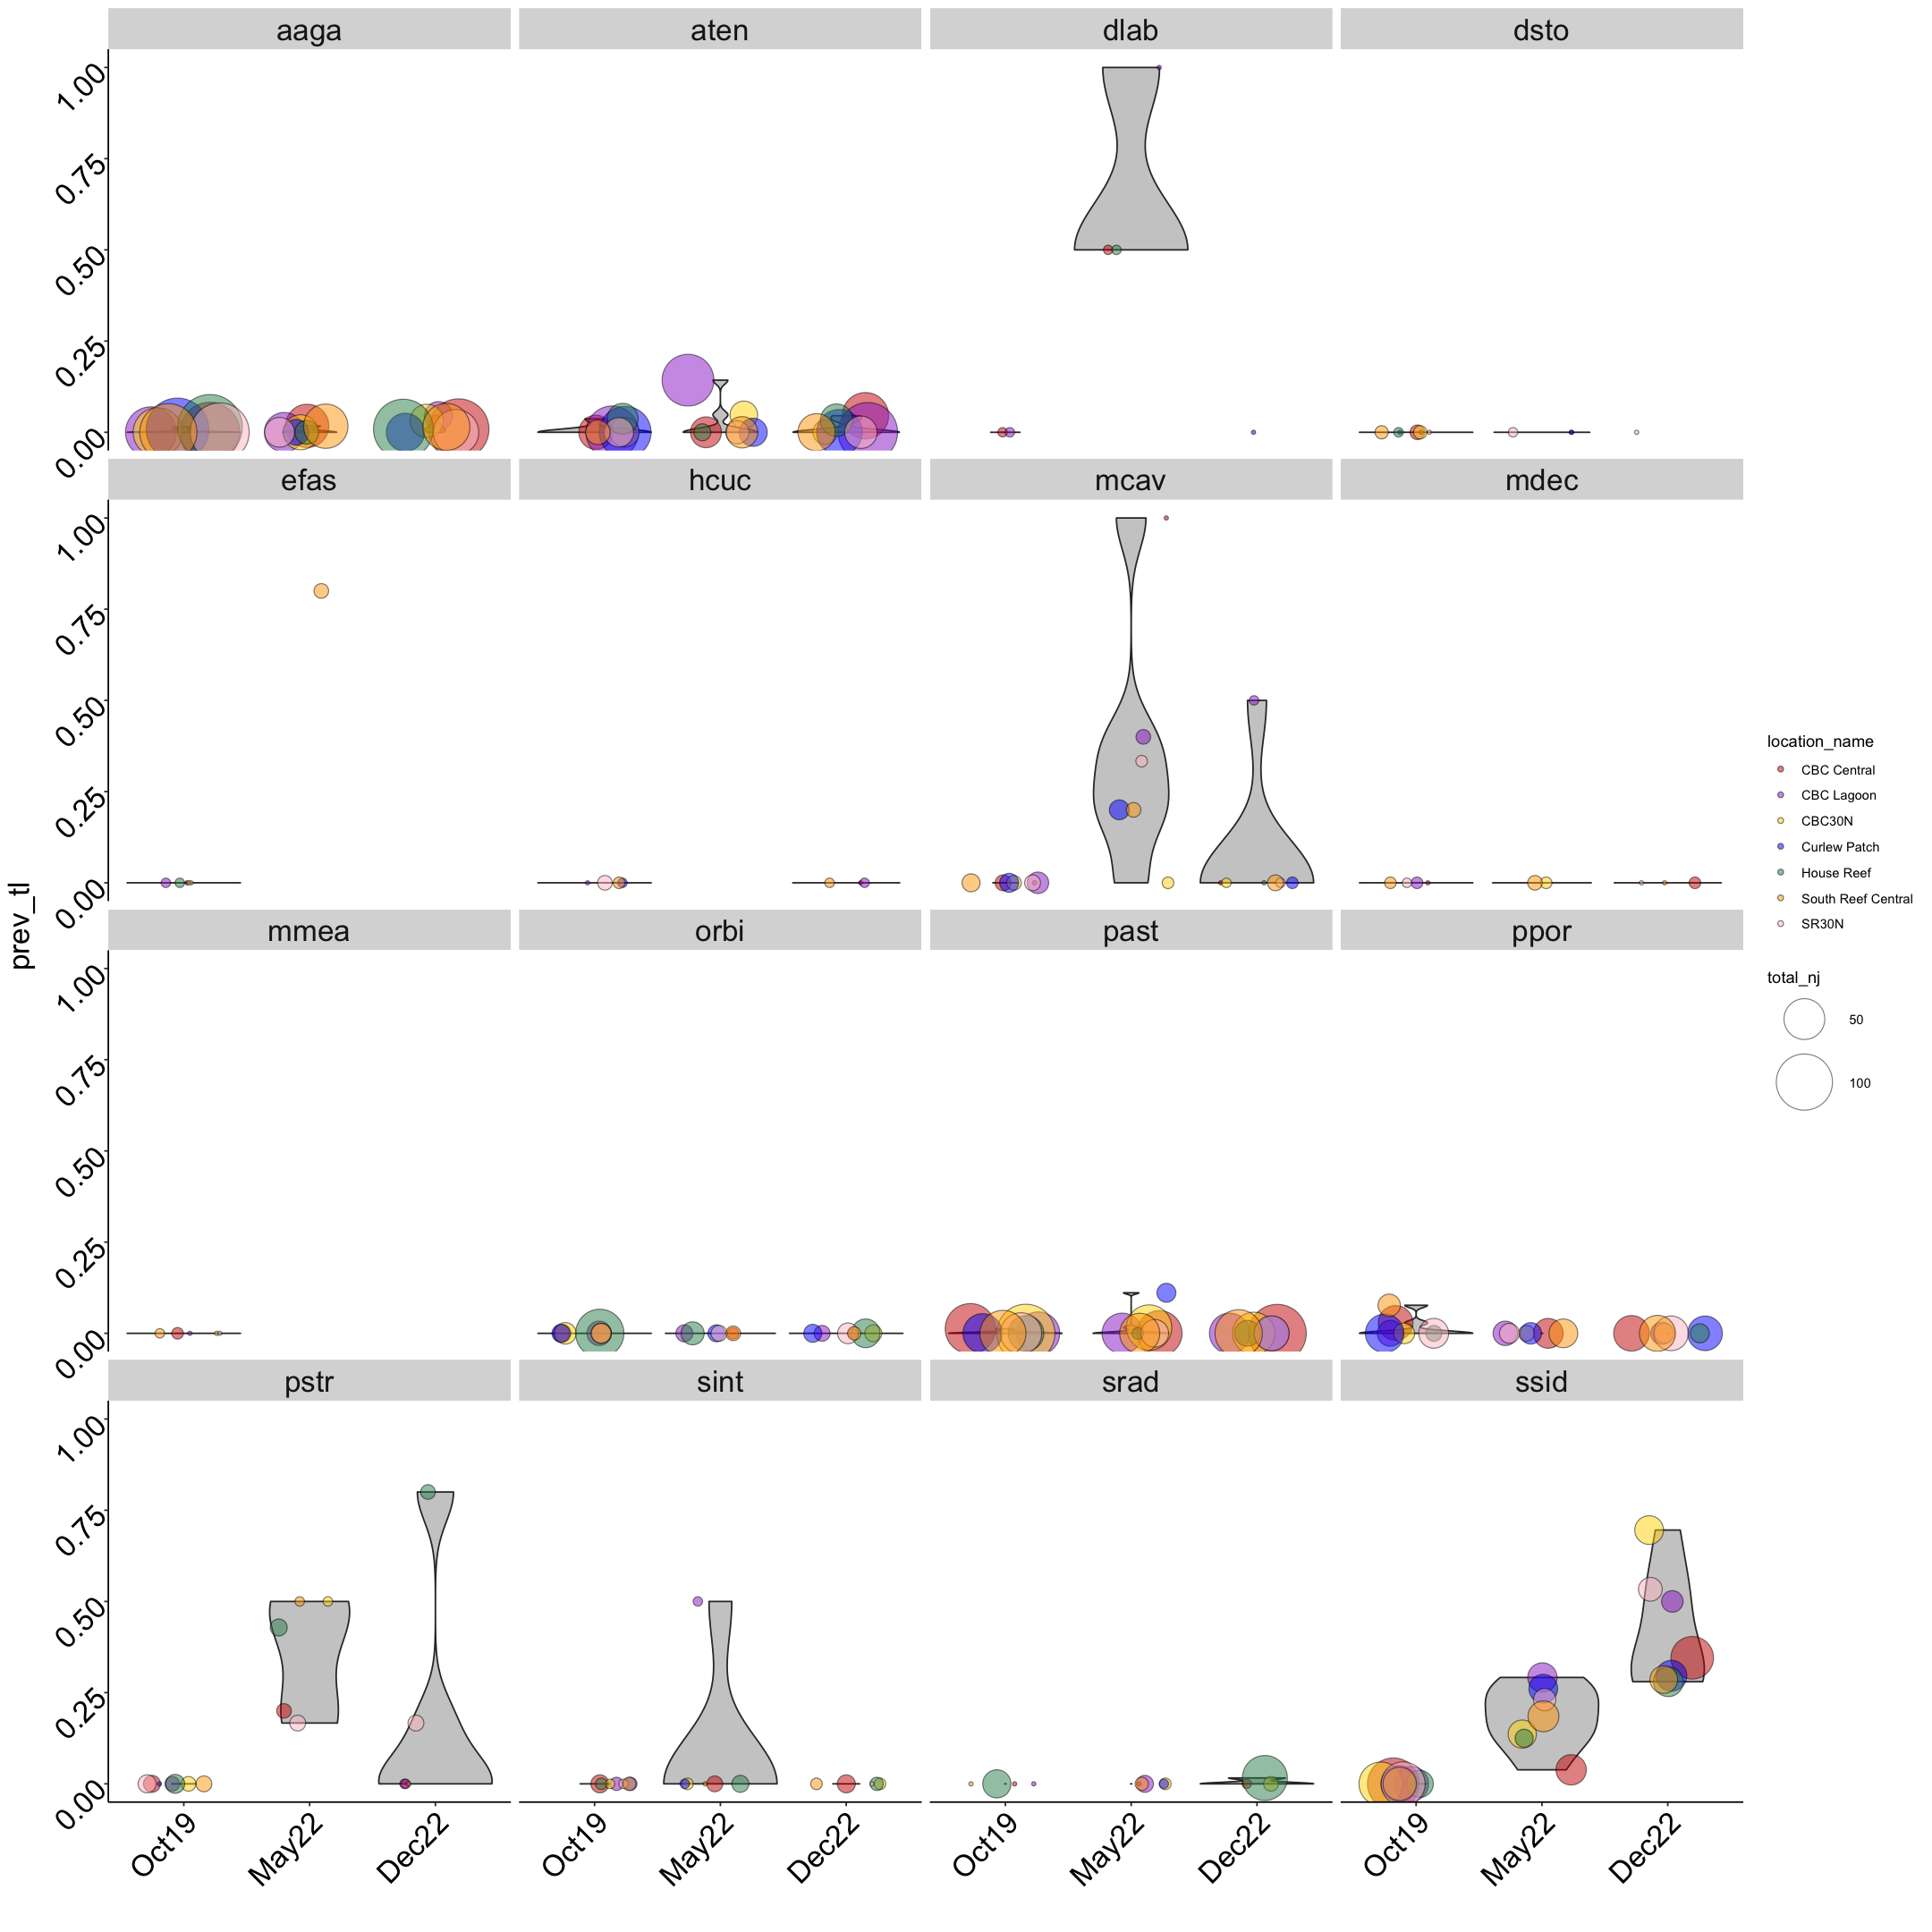

In [453]:
ggplot() +
  geom_violin(data = tldf[!tldf$code.x %in% exclude,], aes(x = time_point.x, y = prev_tl), fill = "gray80", drop=FALSE) +
  geom_jitter(data = tldf[!tldf$code.x %in% exclude,], aes(x = time_point.x, y = prev_tl, fill = location_name.x, size = total_nj), pch = 21, alpha=0.5,  
              width = 0.3, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code.x, ncol = 4) +
scale_size(range = c(1, 20))+
 # scale_y_continuous("colonies/30m2") +
#ylim(0,15)+
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))

In [377]:
susceptible=tldf[tldf$code.x %in% c("dlab", "pstr", "mcav", "efas", "ofav", "oann", "ssid"),]

In [378]:
susceptible

time_point.x location_name.x    code.x total_nj
1   Oct19        CBC Central        dlab    2      
2   Oct19        CBC Central        efas    1      
3   Oct19        CBC Central        mcav    6      
4   Oct19        CBC Central        oann    5      
5   Oct19        CBC Central        ofav    3      
6   Oct19        CBC Central        pstr    7      
7   Oct19        CBC Central        ssid   84      
8   Oct19        CBC Lagoon         dlab    2      
9   Oct19        CBC Lagoon         efas    2      
10  Oct19        CBC Lagoon         mcav   12      
11  Oct19        CBC Lagoon         oann   14      
12  Oct19        CBC Lagoon         ofav    2      
13  Oct19        CBC Lagoon         pstr    5      
14  Oct19        CBC Lagoon         ssid   35      
15  Oct19        CBC30N             efas    1      
16  Oct19        CBC30N             mcav    5      
17  Oct19        CBC30N             oann    9      
18  Oct19        CBC30N             ofav    3      
19  Oct19        CBC30N             pstr    5      
20  Oct19        CBC30N             ssid   58      
21  Oct19        Curlew Patch       mcav    9      
22  Oct19        Curlew Patch       oann    4      
23  Oct19        Curlew Patch       ofav    4      
24  Oct19        Curlew Patch       pstr    1      
25  Oct19        Curlew Patch       ssid   39      
26  Oct19        House Reef         efas    2      
27  Oct19        House Reef         mcav    1      
28  Oct19        House Reef         oann   71      
29  Oct19        House Reef         ofav    1      
30  Oct19        House Reef         pstr    9      
⋮   ⋮            ⋮                  ⋮      ⋮       
73  Dec22        CBC Central        ofav    2      
74  Dec22        CBC Central        pstr    2      
75  Dec22        CBC Central        ssid   55      
76  Dec22        CBC Lagoon         mcav    2      
77  Dec22        CBC Lagoon         oann    6      
78  Dec22        CBC Lagoon         pstr    2      
79  Dec22        CBC Lagoon         ssid   12      
80  Dec22        CBC30N             mcav    2      
81  Dec22        CBC30N             oann    5      
82  Dec22        CBC30N             ofav    1      
83  Dec22        CBC30N             ssid   23      
84  Dec22        Curlew Patch       dlab    1      
85  Dec22        Curlew Patch       mcav    3      
86  Dec22        Curlew Patch       oann    4      
87  Dec22        Curlew Patch       ofav    4      
88  Dec22        Curlew Patch       ssid   27      
89  Dec22        House Reef         mcav    1      
90  Dec22        House Reef         oann   23      
91  Dec22        House Reef         pstr    5      
92  Dec22        House Reef         ssid   25      
93  Dec22        SR30N              mcav    2      
94  Dec22        SR30N              oann    9      
95  Dec22        SR30N              ofav    2      
96  Dec22        SR30N              pstr    6      
97  Dec22        SR30N              ssid   15      
98  Dec22        South Reef Central mcav    6      
99  Dec22        South Reef Central oann    3      
100 Dec22        South Reef Central ofav    1      
101 Dec22        South Reef Central pstr    1      
102 Dec22        South Reef Central ssid   21      
    Event                         n_tl prev_tl   
1   Oct19_CBC Central_dlab        0    0         
2   Oct19_CBC Central_efas        0    0         
3   Oct19_CBC Central_mcav        0    0         
4   Oct19_CBC Central_oann        0    0         
5   Oct19_CBC Central_ofav        0    0         
6   Oct19_CBC Central_pstr        0    0         
7   Oct19_CBC Central_ssid        0    0         
8   Oct19_CBC Lagoon_dlab         0    0         
9   Oct19_CBC Lagoon_efas         0    0         
10  Oct19_CBC Lagoon_mcav         0    0         
11  Oct19_CBC Lagoon_oann         0    0         
12  Oct19_CBC Lagoon_ofav         0    0         
13  Oct19_CBC Lagoon_pstr         0    0         
14  Oct19_CBC Lagoon_ssid         0    0         
15  Oct19_CBC30N_efas         

Warning message:
“Cannot compute density for groups with fewer than two datapoints.”
Warning message:
“Cannot compute density for groups with fewer than two datapoints.”


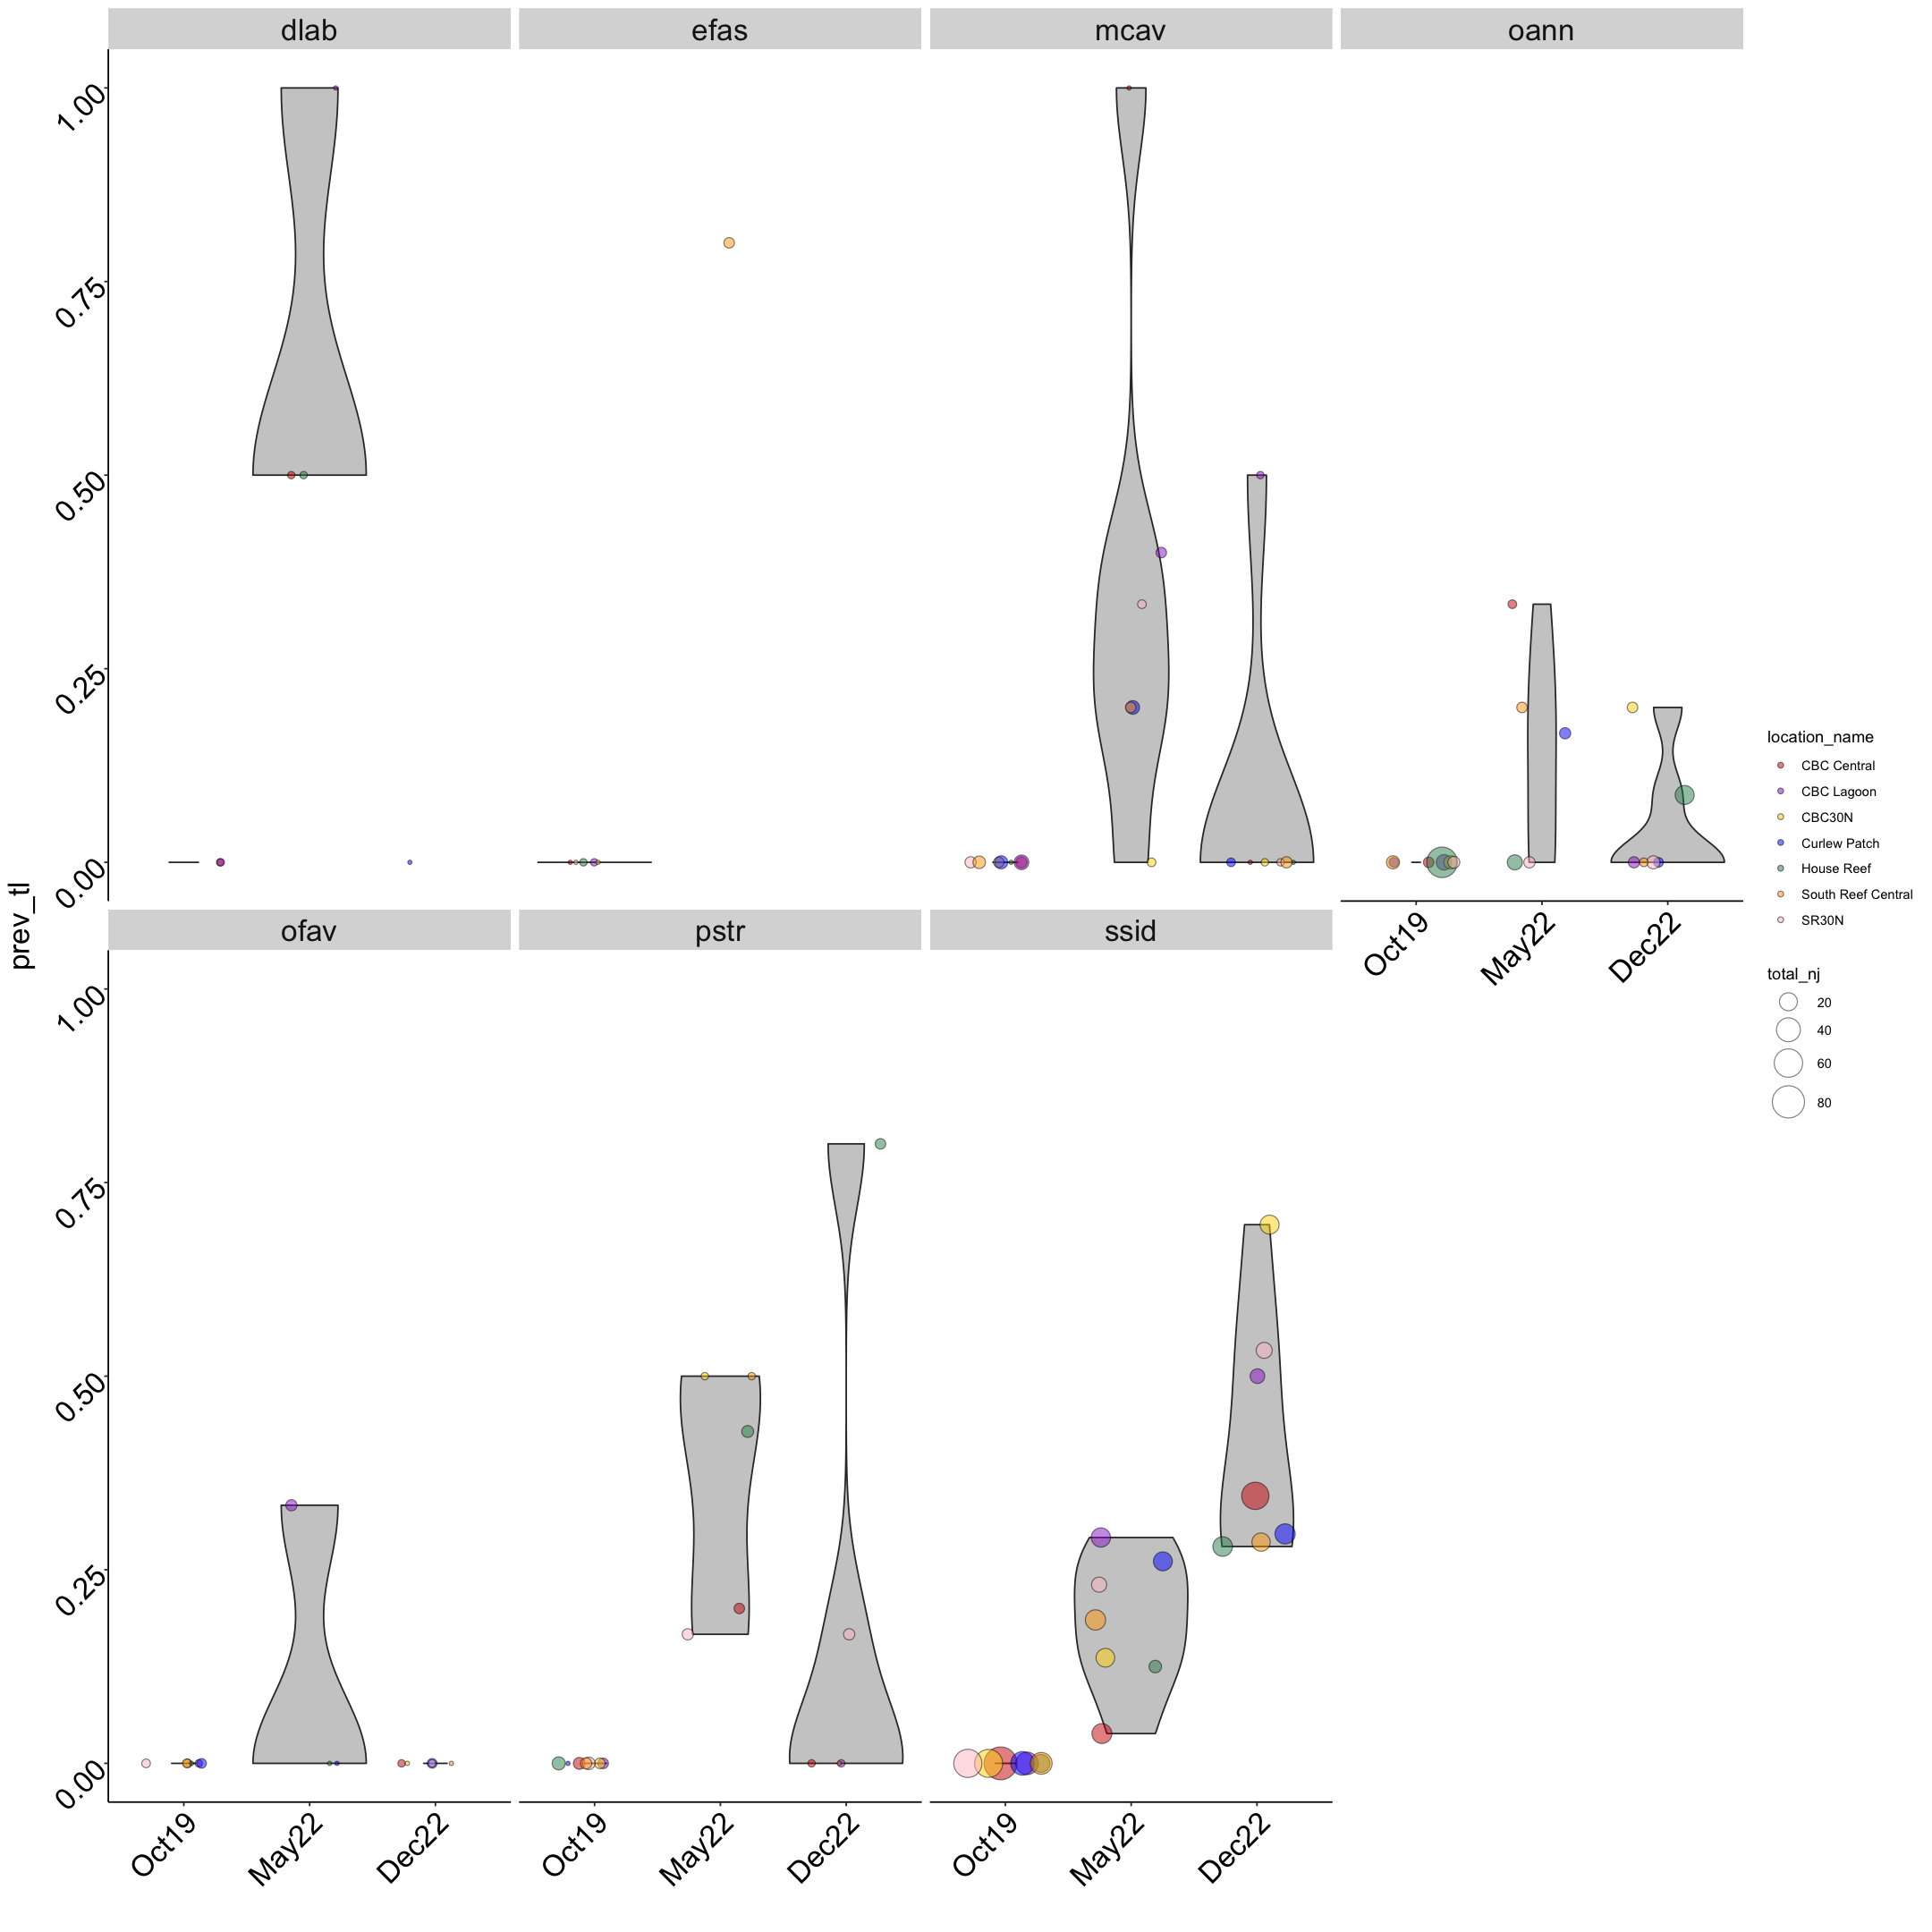

In [382]:
ggplot() +
  geom_violin(data = susceptible, aes(x = time_point.x, y = prev_tl), fill = "gray80", drop=FALSE) +
  geom_jitter(data = susceptible, aes(x = time_point.x, y = prev_tl, fill = location_name.x, size = total_nj), pch = 21, alpha=0.5,  
              width = 0.3, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code.x, ncol = 4) +
scale_size(range = c(1, 10))+
 # scale_y_continuous("colonies/30m2") +
#ylim(0,15)+
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))

In [383]:
resistant=tldf[tldf$code.x %in% c("aten", "aaga", "hcuc", "mdec", "past", "ppor", "srad"),]

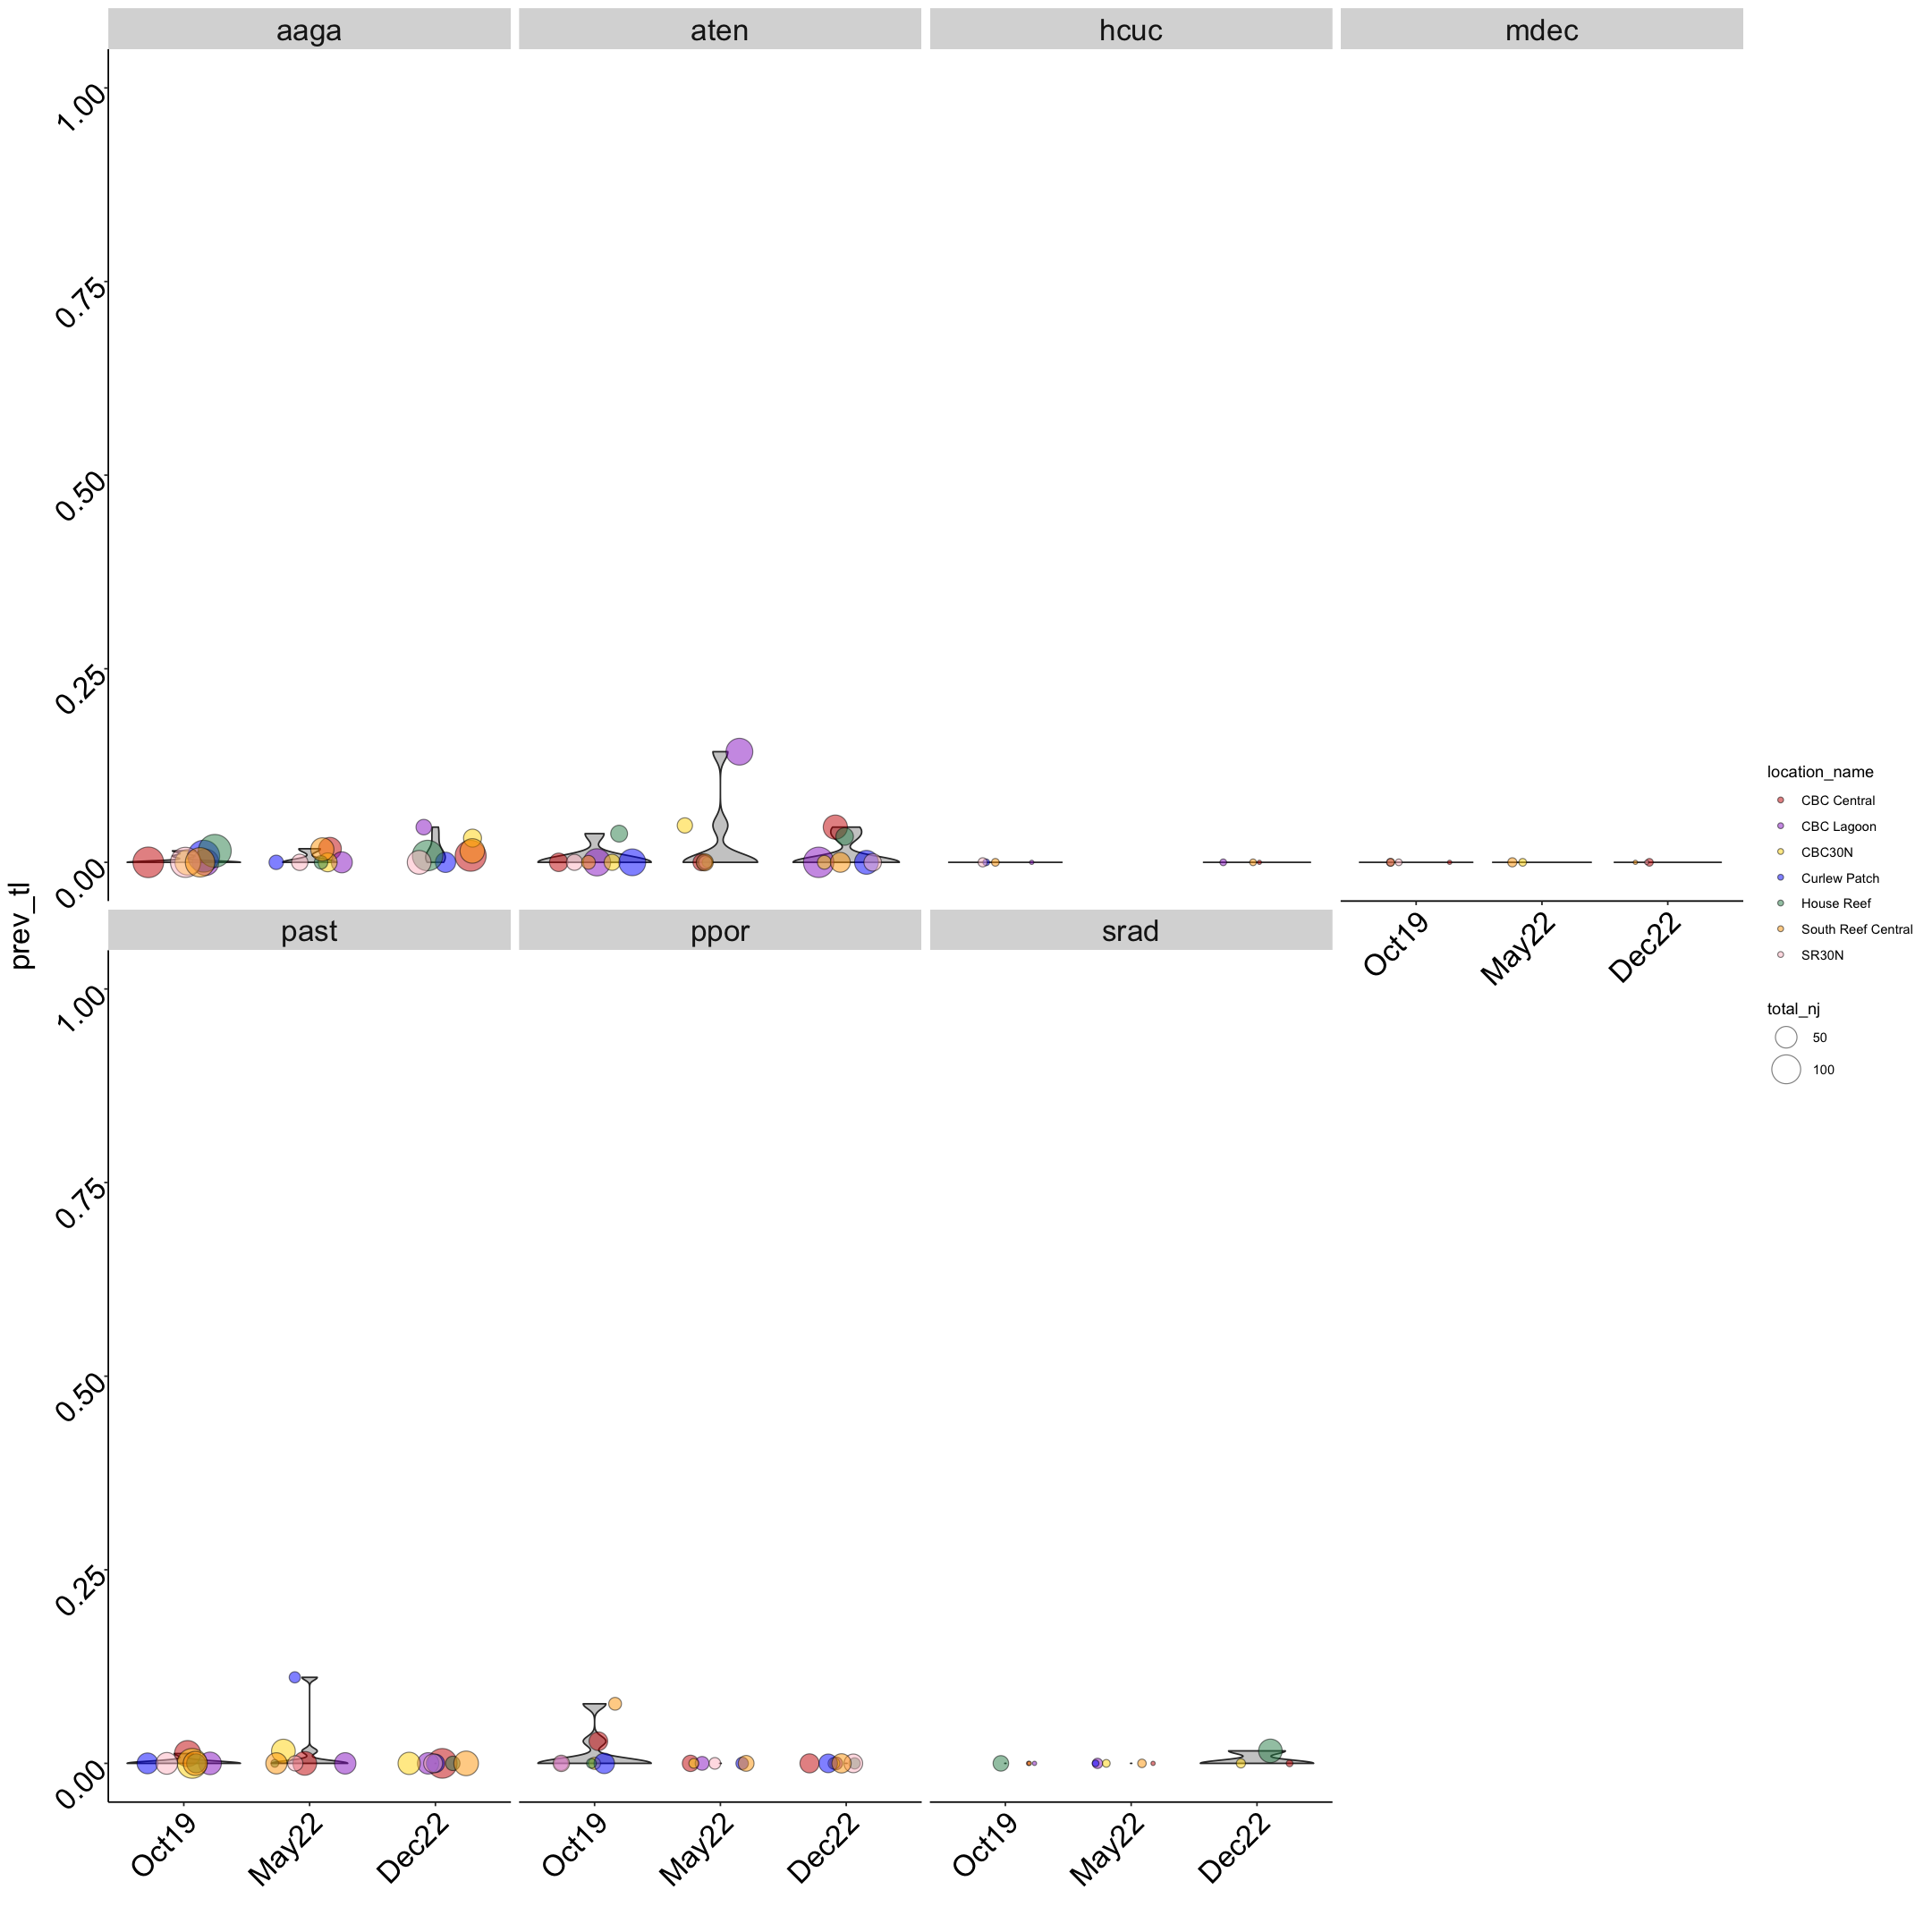

In [385]:
ggplot() +
  geom_violin(data = resistant, aes(x = time_point.x, y = prev_tl), fill = "gray80", drop=FALSE) +
  geom_jitter(data = resistant, aes(x = time_point.x, y = prev_tl, fill = location_name.x, size = total_nj), pch = 21, alpha=0.5,  
              width = 0.3, 
              height = 0) +
  #geom_text(data = suscep1, 
            #aes(x = time_point, y = maxDens, label = Letter), nudge_y = 0.03) + 
  facet_wrap(~code.x, ncol = 4) +
scale_size(range = c(1, 10))+
 # scale_y_continuous("colonies/30m2") +
ylim(0,1)+
  scale_x_discrete("") +
  scale_fill_manual("location_name",values=c(sitecolors)) +
  theme(plot.title = element_text(size = 26,hjust = 0.5),
        strip.text = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"),
        axis.text = element_text(colour = "black", hjust = 1, size = 20, angle = 45),
        axis.title = element_text(size = 20))